In [1]:
!cp -r /kaggle/input/hydracore105 /kaggle/working
!mv /kaggle/working/hydracore105/antlr4-python3-runtime-4.8.tar.gz.tmp /kaggle/working/hydracore105/antlr4-python3-runtime-4.8.tar.gz
!ls /kaggle/working/hydracore105
!pip install /kaggle/working/hydracore105/omegaconf-2.0.5-py3-none-any.whl
!pip install /kaggle/working/hydracore105/antlr4-python3-runtime-4.8.tar.gz

PyYAML-5.4b2-cp37-cp37m-manylinux1_x86_64.whl
antlr4-python3-runtime-4.8.tar.gz
hydra_core-1.0.5-py3-none-any.whl
importlib_resources-5.0.0-py3-none-any.whl
omegaconf-2.0.5-py3-none-any.whl
typing_extensions-3.7.4.3-py3-none-any.whl
zipp-3.4.0-py3-none-any.whl
Processing ./hydracore105/omegaconf-2.0.5-py3-none-any.whl
Processing ./hydracore105/antlr4-python3-runtime-4.8.tar.gz
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=b5334a2ab3cea53c2b6ef524b9677a6cf17259ebe9da4dc9d1497d984f4ab903
  Stored in directory: /root/.cache/pip/wheels/c7/79/15/c9caa87b6ca8f7614a6198dd8e2111f8f909088b97f736d303
Successfully built antlr4-python3-runtime


In [2]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron06 --no-index --find-links ../input/detectron-05/whls

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272235 sha256=df41a905e790ee596412efaef54697a1ffff2e6e3a7c574be01350717627a741
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [3]:
!cd ../input/weighted-boxes-fusion && pip install .

Processing /kaggle/input/weighted-boxes-fusion
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for ensemble-boxes: filename=ensemble_boxes-1.0.7-py3-none-any.whl size=12771 sha256=e430805a427e45757688535b8dd190fadfb82fcb7814bc7135bcf24f5d8ace60
  Stored in directory: /root/.cache/pip/wheels/ae/35/18/ba61cb8c64272476ea91b0238a0ecf044462fa490c09d0467d
Successfully built ensemble-boxes


In [4]:
%%writefile /opt/conda/lib/python3.7/site-packages/detectron2/structures/masks.py
# Copyright (c) Facebook, Inc. and its affiliates.
import copy
from types import SimpleNamespace
import itertools
import numpy as np
from typing import Any, Iterator, List, Union
import pycocotools.mask as mask_util
import torch
from torch import device

from detectron2.layers.roi_align import ROIAlign
from detectron2.utils.memory import retry_if_cuda_oom

from .boxes import Boxes


def polygon_area(x, y):
    # Using the shoelace formula
    # https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


def polygons_to_bitmask(polygons: List[np.ndarray], height: int, width: int) -> np.ndarray:
    """
    Args:
        polygons (list[ndarray]): each array has shape (Nx2,)
        height, width (int)
    Returns:
        ndarray: a bool mask of shape (height, width)
    """
    if len(polygons) == 0:
        # COCOAPI does not support empty polygons
        return np.zeros((height, width)).astype(np.bool)
    rles = mask_util.frPyObjects(polygons, height, width)
    rle = mask_util.merge(rles)
    return mask_util.decode(rle).astype(np.bool)


def rasterize_polygons_within_box(
    polygons: List[np.ndarray], box: np.ndarray, mask_size: int
) -> torch.Tensor:
    """
    Rasterize the polygons into a mask image and
    crop the mask content in the given box.
    The cropped mask is resized to (mask_size, mask_size).
    This function is used when generating training targets for mask head in Mask R-CNN.
    Given original ground-truth masks for an image, new ground-truth mask
    training targets in the size of `mask_size x mask_size`
    must be provided for each predicted box. This function will be called to
    produce such targets.
    Args:
        polygons (list[ndarray[float]]): a list of polygons, which represents an instance.
        box: 4-element numpy array
        mask_size (int):
    Returns:
        Tensor: BoolTensor of shape (mask_size, mask_size)
    """
    # 1. Shift the polygons w.r.t the boxes
    w, h = box[2] - box[0], box[3] - box[1]

    polygons = copy.deepcopy(polygons)
    for p in polygons:
        p[0::2] = p[0::2] - box[0]
        p[1::2] = p[1::2] - box[1]

    # 2. Rescale the polygons to the new box size
    # max() to avoid division by small number
    ratio_h = mask_size / max(h, 0.1)
    ratio_w = mask_size / max(w, 0.1)

    if ratio_h == ratio_w:
        for p in polygons:
            p *= ratio_h
    else:
        for p in polygons:
            p[0::2] *= ratio_w
            p[1::2] *= ratio_h

    # 3. Rasterize the polygons with coco api
    mask = polygons_to_bitmask(polygons, mask_size, mask_size)
    mask = torch.from_numpy(mask)
    return mask


class BitMasks:
    """
    This class stores the segmentation masks for all objects in one image, in
    the form of bitmaps.
    Attributes:
        tensor: bool Tensor of N,H,W, representing N instances in the image.
    """

    def __init__(self, tensor: Union[torch.Tensor, np.ndarray]):
        """
        Args:
            tensor: bool Tensor of N,H,W, representing N instances in the image.
        """
        device = tensor.device if isinstance(tensor, torch.Tensor) else torch.device("cpu")
        tensor = torch.as_tensor(tensor, dtype=torch.bool, device=device)
        assert tensor.dim() == 3, tensor.size()
        self.image_size = tensor.shape[1:]
        self.tensor = tensor

    @torch.jit.unused
    def to(self, *args: Any, **kwargs: Any) -> "BitMasks":
        return BitMasks(self.tensor.to(*args, **kwargs))

    @property
    def device(self) -> torch.device:
        return self.tensor.device

    @torch.jit.unused
    def __getitem__(self, item: Union[int, slice, torch.BoolTensor]) -> "BitMasks":
        """
        Returns:
            BitMasks: Create a new :class:`BitMasks` by indexing.
        The following usage are allowed:
        1. `new_masks = masks[3]`: return a `BitMasks` which contains only one mask.
        2. `new_masks = masks[2:10]`: return a slice of masks.
        3. `new_masks = masks[vector]`, where vector is a torch.BoolTensor
           with `length = len(masks)`. Nonzero elements in the vector will be selected.
        Note that the returned object might share storage with this object,
        subject to Pytorch's indexing semantics.
        """
        if isinstance(item, int):
            return BitMasks(self.tensor[item].unsqueeze(0))
        m = self.tensor[item]
        assert m.dim() == 3, "Indexing on BitMasks with {} returns a tensor with shape {}!".format(
            item, m.shape
        )
        return BitMasks(m)

    @torch.jit.unused
    def __iter__(self) -> torch.Tensor:
        yield from self.tensor

    @torch.jit.unused
    def __repr__(self) -> str:
        s = self.__class__.__name__ + "("
        s += "num_instances={})".format(len(self.tensor))
        return s

    def __len__(self) -> int:
        return self.tensor.shape[0]

    def nonempty(self) -> torch.Tensor:
        """
        Find masks that are non-empty.
        Returns:
            Tensor: a BoolTensor which represents
                whether each mask is empty (False) or non-empty (True).
        """
        return self.tensor.flatten(1).any(dim=1)

    @staticmethod
    def from_polygon_masks(
        polygon_masks: Union["PolygonMasks", List[List[np.ndarray]]], height: int, width: int
    ) -> "BitMasks":
        """
        Args:
            polygon_masks (list[list[ndarray]] or PolygonMasks)
            height, width (int)
        """
        if isinstance(polygon_masks, PolygonMasks):
            polygon_masks = polygon_masks.polygons
        masks = [polygons_to_bitmask(p, height, width) for p in polygon_masks]
        if len(masks):
            return BitMasks(torch.stack([torch.from_numpy(x) for x in masks]))
        else:
            return BitMasks(torch.empty(0, height, width, dtype=torch.bool))

    @staticmethod
    def from_roi_masks(roi_masks: "ROIMasks", height: int, width: int) -> "BitMasks":
        """
        Args:
            roi_masks:
            height, width (int):
        """
        return roi_masks.to_bitmasks(height, width)

    def crop_and_resize(self, boxes: torch.Tensor, mask_size: int) -> torch.Tensor:
        """
        Crop each bitmask by the given box, and resize results to (mask_size, mask_size).
        This can be used to prepare training targets for Mask R-CNN.
        It has less reconstruction error compared to rasterization with polygons.
        However we observe no difference in accuracy,
        but BitMasks requires more memory to store all the masks.
        Args:
            boxes (Tensor): Nx4 tensor storing the boxes for each mask
            mask_size (int): the size of the rasterized mask.
        Returns:
            Tensor:
                A bool tensor of shape (N, mask_size, mask_size), where
                N is the number of predicted boxes for this image.
        """
        assert len(boxes) == len(self), "{} != {}".format(len(boxes), len(self))
        device = self.tensor.device

        batch_inds = torch.arange(len(boxes), device=device).to(dtype=boxes.dtype)[:, None]
        rois = torch.cat([batch_inds, boxes], dim=1)  # Nx5

        bit_masks = self.tensor.to(dtype=torch.float32)
        rois = rois.to(device=device)
        output = (
            ROIAlign((mask_size, mask_size), 1.0, 0, aligned=True)
            .forward(bit_masks[:, None, :, :], rois)
            .squeeze(1)
        )
        output = output >= 0.5
        return output

    def get_bounding_boxes(self) -> Boxes:
        """
        Returns:
            Boxes: tight bounding boxes around bitmasks.
            If a mask is empty, it's bounding box will be all zero.
        """
        boxes = torch.zeros(self.tensor.shape[0], 4, dtype=torch.float32)
        x_any = torch.any(self.tensor, dim=1)
        y_any = torch.any(self.tensor, dim=2)
        for idx in range(self.tensor.shape[0]):
            x = torch.where(x_any[idx, :])[0]
            y = torch.where(y_any[idx, :])[0]
            if len(x) > 0 and len(y) > 0:
                boxes[idx, :] = torch.as_tensor(
                    [x[0], y[0], x[-1] + 1, y[-1] + 1], dtype=torch.float32
                )
        return Boxes(boxes)

    @staticmethod
    def cat(bitmasks_list: List["BitMasks"]) -> "BitMasks":
        """
        Concatenates a list of BitMasks into a single BitMasks
        Arguments:
            bitmasks_list (list[BitMasks])
        Returns:
            BitMasks: the concatenated BitMasks
        """
        assert isinstance(bitmasks_list, (list, tuple))
        assert len(bitmasks_list) > 0
        assert all(isinstance(bitmask, BitMasks) for bitmask in bitmasks_list)

        cat_bitmasks = type(bitmasks_list[0])(torch.cat([bm.tensor for bm in bitmasks_list], dim=0))
        return cat_bitmasks


class PolygonMasks:
    """
    This class stores the segmentation masks for all objects in one image, in the form of polygons.
    Attributes:
        polygons: list[list[ndarray]]. Each ndarray is a float64 vector representing a polygon.
    """

    def __init__(self, polygons: List[List[Union[torch.Tensor, np.ndarray]]]):
        """
        Arguments:
            polygons (list[list[np.ndarray]]): The first
                level of the list correspond to individual instances,
                the second level to all the polygons that compose the
                instance, and the third level to the polygon coordinates.
                The third level array should have the format of
                [x0, y0, x1, y1, ..., xn, yn] (n >= 3).
        """
        if not isinstance(polygons, list):
            raise ValueError(
                "Cannot create PolygonMasks: Expect a list of list of polygons per image. "
                "Got '{}' instead.".format(type(polygons))
            )

        def _make_array(t: Union[torch.Tensor, np.ndarray]) -> np.ndarray:
            # Use float64 for higher precision, because why not?
            # Always put polygons on CPU (self.to is a no-op) since they
            # are supposed to be small tensors.
            # May need to change this assumption if GPU placement becomes useful
            if isinstance(t, torch.Tensor):
                t = t.cpu().numpy()
            return np.asarray(t).astype("float64")

        def process_polygons(
            polygons_per_instance: List[Union[torch.Tensor, np.ndarray]]
        ) -> List[np.ndarray]:
            if not isinstance(polygons_per_instance, list):
                raise ValueError(
                    "Cannot create polygons: Expect a list of polygons per instance. "
                    "Got '{}' instead.".format(type(polygons_per_instance))
                )
            # transform each polygon to a numpy array
            polygons_per_instance = [_make_array(p) for p in polygons_per_instance]
            for polygon in polygons_per_instance:
                if len(polygon) % 2 != 0 or len(polygon) < 6:
                    raise ValueError(f"Cannot create a polygon from {len(polygon)} coordinates.")
            return polygons_per_instance

        self.polygons: List[List[np.ndarray]] = [
            process_polygons(polygons_per_instance) for polygons_per_instance in polygons
        ]

    def to(self, *args: Any, **kwargs: Any) -> "PolygonMasks":
        return self

    @property
    def device(self) -> torch.device:
        return torch.device("cpu")

    def get_bounding_boxes(self) -> Boxes:
        """
        Returns:
            Boxes: tight bounding boxes around polygon masks.
        """
        boxes = torch.zeros(len(self.polygons), 4, dtype=torch.float32)
        for idx, polygons_per_instance in enumerate(self.polygons):
            minxy = torch.as_tensor([float("inf"), float("inf")], dtype=torch.float32)
            maxxy = torch.zeros(2, dtype=torch.float32)
            for polygon in polygons_per_instance:
                coords = torch.from_numpy(polygon).view(-1, 2).to(dtype=torch.float32)
                minxy = torch.min(minxy, torch.min(coords, dim=0).values)
                maxxy = torch.max(maxxy, torch.max(coords, dim=0).values)
            boxes[idx, :2] = minxy
            boxes[idx, 2:] = maxxy
        return Boxes(boxes)

    def nonempty(self) -> torch.Tensor:
        """
        Find masks that are non-empty.
        Returns:
            Tensor:
                a BoolTensor which represents whether each mask is empty (False) or not (True).
        """
        keep = [1 if len(polygon) > 0 else 0 for polygon in self.polygons]
        return torch.from_numpy(np.asarray(keep, dtype=np.bool))

    def __getitem__(self, item: Union[int, slice, List[int], torch.BoolTensor]) -> "PolygonMasks":
        """
        Support indexing over the instances and return a `PolygonMasks` object.
        `item` can be:
        1. An integer. It will return an object with only one instance.
        2. A slice. It will return an object with the selected instances.
        3. A list[int]. It will return an object with the selected instances,
           correpsonding to the indices in the list.
        4. A vector mask of type BoolTensor, whose length is num_instances.
           It will return an object with the instances whose mask is nonzero.
        """
        if isinstance(item, int):
            selected_polygons = [self.polygons[item]]
        elif isinstance(item, slice):
            selected_polygons = self.polygons[item]
        elif isinstance(item, list):
            selected_polygons = [self.polygons[i] for i in item]
        elif isinstance(item, torch.Tensor):
            # Polygons is a list, so we have to move the indices back to CPU.
            if item.dtype == torch.bool:
                assert item.dim() == 1, item.shape
                item = item.nonzero().squeeze(1).cpu().numpy().tolist()
            elif item.dtype in [torch.int32, torch.int64]:
                item = item.cpu().numpy().tolist()
            else:
                raise ValueError("Unsupported tensor dtype={} for indexing!".format(item.dtype))
            selected_polygons = [self.polygons[i] for i in item]
        return PolygonMasks(selected_polygons)

    def __iter__(self) -> Iterator[List[np.ndarray]]:
        """
        Yields:
            list[ndarray]: the polygons for one instance.
            Each Tensor is a float64 vector representing a polygon.
        """
        return iter(self.polygons)

    def __repr__(self) -> str:
        s = self.__class__.__name__ + "("
        s += "num_instances={})".format(len(self.polygons))
        return s

    def __len__(self) -> int:
        return len(self.polygons)

    def crop_and_resize(self, boxes: torch.Tensor, mask_size: int) -> torch.Tensor:
        """
        Crop each mask by the given box, and resize results to (mask_size, mask_size).
        This can be used to prepare training targets for Mask R-CNN.
        Args:
            boxes (Tensor): Nx4 tensor storing the boxes for each mask
            mask_size (int): the size of the rasterized mask.
        Returns:
            Tensor: A bool tensor of shape (N, mask_size, mask_size), where
            N is the number of predicted boxes for this image.
        """
        assert len(boxes) == len(self), "{} != {}".format(len(boxes), len(self))

        device = boxes.device
        # Put boxes on the CPU, as the polygon representation is not efficient GPU-wise
        # (several small tensors for representing a single instance mask)
        boxes = boxes.to(torch.device("cpu"))

        results = [
            rasterize_polygons_within_box(poly, box.numpy(), mask_size)
            for poly, box in zip(self.polygons, boxes)
        ]
        """
        poly: list[list[float]], the polygons for one instance
        box: a tensor of shape (4,)
        """
        if len(results) == 0:
            return torch.empty(0, mask_size, mask_size, dtype=torch.bool, device=device)
        return torch.stack(results, dim=0).to(device=device)

    def area(self):
        """
        Computes area of the mask.
        Only works with Polygons, using the shoelace formula:
        https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
        Returns:
            Tensor: a vector, area for each instance
        """

        area = []
        for polygons_per_instance in self.polygons:
            area_per_instance = 0
            for p in polygons_per_instance:
                area_per_instance += polygon_area(p[0::2], p[1::2])
            area.append(area_per_instance)

        return torch.tensor(area)

    @staticmethod
    def cat(polymasks_list: List["PolygonMasks"]) -> "PolygonMasks":
        """
        Concatenates a list of PolygonMasks into a single PolygonMasks
        Arguments:
            polymasks_list (list[PolygonMasks])
        Returns:
            PolygonMasks: the concatenated PolygonMasks
        """
        assert isinstance(polymasks_list, (list, tuple))
        assert len(polymasks_list) > 0
        assert all(isinstance(polymask, PolygonMasks) for polymask in polymasks_list)

        cat_polymasks = type(polymasks_list[0])(
            list(itertools.chain.from_iterable(pm.polygons for pm in polymasks_list))
        )
        return cat_polymasks


class ROIMasks:
    """
    Represent masks by N smaller masks defined in some ROIs. Once ROI boxes are given,
    full-image bitmask can be obtained by "pasting" the mask on the region defined
    by the corresponding ROI box.
    """

    def __init__(self, tensor: torch.Tensor):
        """
        Args:
            tensor: (N, M, M) mask tensor that defines the mask within each ROI.
        """
        if tensor.dim() != 3:
            raise ValueError("ROIMasks must take a masks of 3 dimension.")
        self.tensor = tensor

    def to(self, device: torch.device) -> "ROIMasks":
        return ROIMasks(self.tensor.to(device))

    @property
    def device(self) -> device:
        return self.tensor.device

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, item) -> "ROIMasks":
        """
        Returns:
            ROIMasks: Create a new :class:`ROIMasks` by indexing.
        The following usage are allowed:
        1. `new_masks = masks[2:10]`: return a slice of masks.
        2. `new_masks = masks[vector]`, where vector is a torch.BoolTensor
           with `length = len(masks)`. Nonzero elements in the vector will be selected.
        Note that the returned object might share storage with this object,
        subject to Pytorch's indexing semantics.
        """
        t = self.tensor[item]
        if t.dim() != 3:
            raise ValueError(
                f"Indexing on ROIMasks with {item} returns a tensor with shape {t.shape}!"
            )
        return ROIMasks(t)

    @torch.jit.unused
    def __repr__(self) -> str:
        s = self.__class__.__name__ + "("
        s += "num_instances={})".format(len(self.tensor))
        return s

    @torch.jit.unused
    def to_bitmasks(self, boxes: torch.Tensor, height, width, threshold=0.5):
        """
        Args: see documentation of :func:`paste_masks_in_image`.
        """
        from detectron2.layers.mask_ops import paste_masks_in_image, _paste_masks_tensor_shape

        if torch.jit.is_tracing():
            if isinstance(height, torch.Tensor):
                paste_func = _paste_masks_tensor_shape
            else:
                paste_func = paste_masks_in_image
        else:
            paste_func = retry_if_cuda_oom(paste_masks_in_image)
        bitmasks = paste_func(self.tensor, boxes.tensor, (height, width), threshold=threshold)
#         return BitMasks(bitmasks)
        return SimpleNamespace(tensor=bitmasks)

Overwriting /opt/conda/lib/python3.7/site-packages/detectron2/structures/masks.py


In [5]:
%%writefile /opt/conda/lib/python3.7/site-packages/detectron2/layers/mask_ops.py
# Copyright (c) Facebook, Inc. and its affiliates.
import numpy as np
from typing import Tuple
import torch
from PIL import Image
from torch.nn import functional as F

__all__ = ["paste_masks_in_image"]


BYTES_PER_FLOAT = 4
# TODO: This memory limit may be too much or too little. It would be better to
# determine it based on available resources.
GPU_MEM_LIMIT = 1024 ** 3  # 1 GB memory limit


def _do_paste_mask(masks, boxes, img_h: int, img_w: int, skip_empty: bool = True):
    """
    Args:
        masks: N, 1, H, W
        boxes: N, 4
        img_h, img_w (int):
        skip_empty (bool): only paste masks within the region that
            tightly bound all boxes, and returns the results this region only.
            An important optimization for CPU.
    Returns:
        if skip_empty == False, a mask of shape (N, img_h, img_w)
        if skip_empty == True, a mask of shape (N, h', w'), and the slice
            object for the corresponding region.
    """
    # On GPU, paste all masks together (up to chunk size)
    # by using the entire image to sample the masks
    # Compared to pasting them one by one,
    # this has more operations but is faster on COCO-scale dataset.
    device = masks.device

    if skip_empty and not torch.jit.is_scripting():
        x0_int, y0_int = torch.clamp(boxes.min(dim=0).values.floor()[:2] - 1, min=0).to(
            dtype=torch.int32
        )
        x1_int = torch.clamp(boxes[:, 2].max().ceil() + 1, max=img_w).to(dtype=torch.int32)
        y1_int = torch.clamp(boxes[:, 3].max().ceil() + 1, max=img_h).to(dtype=torch.int32)
    else:
        x0_int, y0_int = 0, 0
        x1_int, y1_int = img_w, img_h
    x0, y0, x1, y1 = torch.split(boxes, 1, dim=1)  # each is Nx1

    N = masks.shape[0]

    img_y = torch.arange(y0_int, y1_int, device=device, dtype=torch.float32) + 0.5
    img_x = torch.arange(x0_int, x1_int, device=device, dtype=torch.float32) + 0.5
    img_y = (img_y - y0) / (y1 - y0) * 2 - 1
    img_x = (img_x - x0) / (x1 - x0) * 2 - 1
    # img_x, img_y have shapes (N, w), (N, h)

    gx = img_x[:, None, :].expand(N, img_y.size(1), img_x.size(1))
    gy = img_y[:, :, None].expand(N, img_y.size(1), img_x.size(1))
    grid = torch.stack([gx, gy], dim=3)

    if not torch.jit.is_scripting():
        if not masks.dtype.is_floating_point:
            masks = masks.float()
    img_masks = F.grid_sample(masks, grid.to(masks.dtype), align_corners=False)

    if skip_empty and not torch.jit.is_scripting():
        return img_masks[:, 0], (slice(y0_int, y1_int), slice(x0_int, x1_int))
    else:
        return img_masks[:, 0], ()


# Annotate boxes as Tensor (but not Boxes) in order to use scripting
@torch.jit.script_if_tracing
# def paste_masks_in_image(
#     masks: torch.Tensor, boxes: torch.Tensor, image_shape: Tuple[int, int], threshold: float = 0.5
# ):
#     """
#     Paste a set of masks that are of a fixed resolution (e.g., 28 x 28) into an image.
#     The location, height, and width for pasting each mask is determined by their
#     corresponding bounding boxes in boxes.
#     Note:
#         This is a complicated but more accurate implementation. In actual deployment, it is
#         often enough to use a faster but less accurate implementation.
#         See :func:`paste_mask_in_image_old` in this file for an alternative implementation.
#     Args:
#         masks (tensor): Tensor of shape (Bimg, Hmask, Wmask), where Bimg is the number of
#             detected object instances in the image and Hmask, Wmask are the mask width and mask
#             height of the predicted mask (e.g., Hmask = Wmask = 28). Values are in [0, 1].
#         boxes (Boxes or Tensor): A Boxes of length Bimg or Tensor of shape (Bimg, 4).
#             boxes[i] and masks[i] correspond to the same object instance.
#         image_shape (tuple): height, width
#         threshold (float): A threshold in [0, 1] for converting the (soft) masks to
#             binary masks.
#     Returns:
#         img_masks (Tensor): A tensor of shape (Bimg, Himage, Wimage), where Bimg is the
#         number of detected object instances and Himage, Wimage are the image width
#         and height. img_masks[i] is a binary mask for object instance i.
#     """

#     assert masks.shape[-1] == masks.shape[-2], "Only square mask predictions are supported"
#     N = len(masks)
#     if N == 0:
#         return masks.new_empty((0,) + image_shape, dtype=torch.uint8)
#     if not isinstance(boxes, torch.Tensor):
#         boxes = boxes.tensor
#     device = boxes.device
#     assert len(boxes) == N, boxes.shape

#     img_h, img_w = image_shape

#     # The actual implementation split the input into chunks,
#     # and paste them chunk by chunk.
#     if device.type == "cpu" or torch.jit.is_scripting():
#         # CPU is most efficient when they are pasted one by one with skip_empty=True
#         # so that it performs minimal number of operations.
#         num_chunks = N
#     else:
#         # GPU benefits from parallelism for larger chunks, but may have memory issue
#         # int(img_h) because shape may be tensors in tracing
#         num_chunks = int(np.ceil(N * int(img_h) * int(img_w) * BYTES_PER_FLOAT / GPU_MEM_LIMIT))
#         assert (
#             num_chunks <= N
#         ), "Default GPU_MEM_LIMIT in mask_ops.py is too small; try increasing it"
#     chunks = torch.chunk(torch.arange(N, device=device), num_chunks)

#     img_masks = torch.zeros(
#         N, img_h, img_w, device=device, dtype=torch.bool if threshold >= 0 else torch.uint8
#     )
#     for inds in chunks:
#         masks_chunk, spatial_inds = _do_paste_mask(
#             masks[inds, None, :, :], boxes[inds], img_h, img_w, skip_empty=device.type == "cpu"
#         )

#         if threshold >= 0:
#             masks_chunk = (masks_chunk >= threshold).to(dtype=torch.bool)
#         else:
#             # for visualization and debugging
#             masks_chunk = (masks_chunk * 255).to(dtype=torch.uint8)

#         if torch.jit.is_scripting():  # Scripting does not use the optimized codepath
#             img_masks[inds] = masks_chunk
#         else:
#             img_masks[(inds,) + spatial_inds] = masks_chunk
#     return img_masks

def paste_masks_in_image(masks: torch.Tensor, boxes: torch.Tensor, image_shape: Tuple[int, int], threshold: float = 0.5):
    """
    Copy pasted from detectron2.layers.mask_ops.paste_masks_in_image and deleted thresholding of the mask
    """
    assert masks.shape[-1] == masks.shape[-2], "Only square mask predictions are supported"
    N = len(masks)
    if N == 0:
        return masks.new_empty((0,) + image_shape, dtype=torch.uint8)
    if not isinstance(boxes, torch.Tensor):
        boxes = boxes.tensor
    device = boxes.device
    assert len(boxes) == N, boxes.shape

    img_h, img_w = image_shape

    # The actual implementation split the input into chunks,
    # and paste them chunk by chunk.
    if device.type == "cpu":
        # CPU is most efficient when they are pasted one by one with skip_empty=True
        # so that it performs minimal number of operations.
        num_chunks = N
    else:
        # GPU benefits from parallelism for larger chunks, but may have memory issue
        num_chunks = int(np.ceil(N * img_h * img_w * BYTES_PER_FLOAT / GPU_MEM_LIMIT))
        assert (
            num_chunks <= N
        ), "Default GPU_MEM_LIMIT in mask_ops.py is too small; try increasing it"
    chunks = torch.chunk(torch.arange(N, device=device), num_chunks)

    img_masks = torch.zeros(
        N, img_h, img_w, device=device, dtype=torch.float32
    )
    for inds in chunks:
        masks_chunk, spatial_inds = _do_paste_mask(
            masks[inds, None, :, :], boxes[inds], img_h, img_w, skip_empty=device.type == "cpu"
        )
        img_masks[(inds,) + spatial_inds] = masks_chunk
    return img_masks

# The below are the original paste function (from Detectron1) which has
# larger quantization error.
# It is faster on CPU, while the aligned one is faster on GPU thanks to grid_sample.


def paste_mask_in_image_old(mask, box, img_h, img_w, threshold):
    """
    Paste a single mask in an image.
    This is a per-box implementation of :func:`paste_masks_in_image`.
    This function has larger quantization error due to incorrect pixel
    modeling and is not used any more.
    Args:
        mask (Tensor): A tensor of shape (Hmask, Wmask) storing the mask of a single
            object instance. Values are in [0, 1].
        box (Tensor): A tensor of shape (4, ) storing the x0, y0, x1, y1 box corners
            of the object instance.
        img_h, img_w (int): Image height and width.
        threshold (float): Mask binarization threshold in [0, 1].
    Returns:
        im_mask (Tensor):
            The resized and binarized object mask pasted into the original
            image plane (a tensor of shape (img_h, img_w)).
    """
    # Conversion from continuous box coordinates to discrete pixel coordinates
    # via truncation (cast to int32). This determines which pixels to paste the
    # mask onto.
    box = box.to(dtype=torch.int32)  # Continuous to discrete coordinate conversion
    # An example (1D) box with continuous coordinates (x0=0.7, x1=4.3) will map to
    # a discrete coordinates (x0=0, x1=4). Note that box is mapped to 5 = x1 - x0 + 1
    # pixels (not x1 - x0 pixels).
    samples_w = box[2] - box[0] + 1  # Number of pixel samples, *not* geometric width
    samples_h = box[3] - box[1] + 1  # Number of pixel samples, *not* geometric height

    # Resample the mask from it's original grid to the new samples_w x samples_h grid
    mask = Image.fromarray(mask.cpu().numpy())
    mask = mask.resize((samples_w, samples_h), resample=Image.BILINEAR)
    mask = np.array(mask, copy=False)

    if threshold >= 0:
        mask = np.array(mask > threshold, dtype=np.uint8)
        mask = torch.from_numpy(mask)
    else:
        # for visualization and debugging, we also
        # allow it to return an unmodified mask
        mask = torch.from_numpy(mask * 255).to(torch.uint8)

    im_mask = torch.zeros((img_h, img_w), dtype=torch.uint8)
    x_0 = max(box[0], 0)
    x_1 = min(box[2] + 1, img_w)
    y_0 = max(box[1], 0)
    y_1 = min(box[3] + 1, img_h)

    im_mask[y_0:y_1, x_0:x_1] = mask[
        (y_0 - box[1]) : (y_1 - box[1]), (x_0 - box[0]) : (x_1 - box[0])
    ]
    return im_mask


# Our pixel modeling requires extrapolation for any continuous
# coordinate < 0.5 or > length - 0.5. When sampling pixels on the masks,
# we would like this extrapolation to be an interpolation between boundary values and zero,
# instead of using absolute zero or boundary values.
# Therefore `paste_mask_in_image_old` is often used with zero padding around the masks like this:
# masks, scale = pad_masks(masks[:, 0, :, :], 1)
# boxes = scale_boxes(boxes.tensor, scale)


def pad_masks(masks, padding):
    """
    Args:
        masks (tensor): A tensor of shape (B, M, M) representing B masks.
        padding (int): Number of cells to pad on all sides.
    Returns:
        The padded masks and the scale factor of the padding size / original size.
    """
    B = masks.shape[0]
    M = masks.shape[-1]
    pad2 = 2 * padding
    scale = float(M + pad2) / M
    padded_masks = masks.new_zeros((B, M + pad2, M + pad2))
    padded_masks[:, padding:-padding, padding:-padding] = masks
    return padded_masks, scale


def scale_boxes(boxes, scale):
    """
    Args:
        boxes (tensor): A tensor of shape (B, 4) representing B boxes with 4
            coords representing the corners x0, y0, x1, y1,
        scale (float): The box scaling factor.
    Returns:
        Scaled boxes.
    """
    w_half = (boxes[:, 2] - boxes[:, 0]) * 0.5
    h_half = (boxes[:, 3] - boxes[:, 1]) * 0.5
    x_c = (boxes[:, 2] + boxes[:, 0]) * 0.5
    y_c = (boxes[:, 3] + boxes[:, 1]) * 0.5

    w_half *= scale
    h_half *= scale

    scaled_boxes = torch.zeros_like(boxes)
    scaled_boxes[:, 0] = x_c - w_half
    scaled_boxes[:, 2] = x_c + w_half
    scaled_boxes[:, 1] = y_c - h_half
    scaled_boxes[:, 3] = y_c + h_half
    return scaled_boxes


@torch.jit.script_if_tracing
def _paste_masks_tensor_shape(
    masks: torch.Tensor,
    boxes: torch.Tensor,
    image_shape: Tuple[torch.Tensor, torch.Tensor],
    threshold: float = 0.5,
):
    """
    A wrapper of paste_masks_in_image where image_shape is Tensor.
    During tracing, shapes might be tensors instead of ints. The Tensor->int
    conversion should be scripted rather than traced.
    """
    return paste_masks_in_image(masks, boxes, (int(image_shape[0]), int(image_shape[1])), threshold)

Overwriting /opt/conda/lib/python3.7/site-packages/detectron2/layers/mask_ops.py


In [6]:
%%writefile /opt/conda/lib/python3.7/site-packages/detectron2/config/defaults.py
# Copyright (c) Facebook, Inc. and its affiliates.
from .config import CfgNode as CN

# -----------------------------------------------------------------------------
# Convention about Training / Test specific parameters
# -----------------------------------------------------------------------------
# Whenever an argument can be either used for training or for testing, the
# corresponding name will be post-fixed by a _TRAIN for a training parameter,
# or _TEST for a test-specific parameter.
# For example, the number of images during training will be
# IMAGES_PER_BATCH_TRAIN, while the number of images for testing will be
# IMAGES_PER_BATCH_TEST

# -----------------------------------------------------------------------------
# Config definition
# -----------------------------------------------------------------------------

_C = CN()

# The version number, to upgrade from old configs to new ones if any
# changes happen. It's recommended to keep a VERSION in your config file.
_C.VERSION = 2

_C.MODEL = CN()
_C.MODEL.LOAD_PROPOSALS = False
_C.MODEL.MASK_ON = False
_C.MODEL.KEYPOINT_ON = False
_C.MODEL.DEVICE = "cuda"
_C.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

# Path (a file path, or URL like detectron2://.., https://..) to a checkpoint file
# to be loaded to the model. You can find available models in the model zoo.
_C.MODEL.WEIGHTS = ""

# Values to be used for image normalization (BGR order, since INPUT.FORMAT defaults to BGR).
# To train on images of different number of channels, just set different mean & std.
# Default values are the mean pixel value from ImageNet: [103.53, 116.28, 123.675]
_C.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675]
# When using pre-trained models in Detectron1 or any MSRA models,
# std has been absorbed into its conv1 weights, so the std needs to be set 1.
# Otherwise, you can use [57.375, 57.120, 58.395] (ImageNet std)
_C.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]


# -----------------------------------------------------------------------------
# INPUT
# -----------------------------------------------------------------------------
_C.INPUT = CN()
# Size of the smallest side of the image during training
_C.INPUT.MIN_SIZE_TRAIN = (800,)
# Sample size of smallest side by choice or random selection from range give by
# INPUT.MIN_SIZE_TRAIN
_C.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# Maximum size of the side of the image during training
_C.INPUT.MAX_SIZE_TRAIN = 1333
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
_C.INPUT.MIN_SIZE_TEST = 800
# Maximum size of the side of the image during testing
_C.INPUT.MAX_SIZE_TEST = 1333
# Mode for flipping images used in data augmentation during training
# choose one of ["horizontal, "vertical", "none"]
_C.INPUT.RANDOM_FLIP = "horizontal"

# `True` if cropping is used for data augmentation during training
_C.INPUT.CROP = CN({"ENABLED": False})
# Cropping type. See documentation of `detectron2.data.transforms.RandomCrop` for explanation.
_C.INPUT.CROP.TYPE = "relative_range"
# Size of crop in range (0, 1] if CROP.TYPE is "relative" or "relative_range" and in number of
# pixels if CROP.TYPE is "absolute"
_C.INPUT.CROP.SIZE = [0.9, 0.9]


# Whether the model needs RGB, YUV, HSV etc.
# Should be one of the modes defined here, as we use PIL to read the image:
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
# with BGR being the one exception. One can set image format to BGR, we will
# internally use RGB for conversion and flip the channels over
_C.INPUT.FORMAT = "BGR"
# The ground truth mask format that the model will use.
# Mask R-CNN supports either "polygon" or "bitmask" as ground truth.
_C.INPUT.MASK_FORMAT = "polygon"  # alternative: "bitmask"


# -----------------------------------------------------------------------------
# Dataset
# -----------------------------------------------------------------------------
_C.DATASETS = CN()
# List of the dataset names for training. Must be registered in DatasetCatalog
# Samples from these datasets will be merged and used as one dataset.
_C.DATASETS.TRAIN = ()
# List of the pre-computed proposal files for training, which must be consistent
# with datasets listed in DATASETS.TRAIN.
_C.DATASETS.PROPOSAL_FILES_TRAIN = ()
# Number of top scoring precomputed proposals to keep for training
_C.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN = 2000
# List of the dataset names for testing. Must be registered in DatasetCatalog
_C.DATASETS.TEST = ()
# List of the pre-computed proposal files for test, which must be consistent
# with datasets listed in DATASETS.TEST.
_C.DATASETS.PROPOSAL_FILES_TEST = ()
# Number of top scoring precomputed proposals to keep for test
_C.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST = 1000

# -----------------------------------------------------------------------------
# DataLoader
# -----------------------------------------------------------------------------
_C.DATALOADER = CN()
# Number of data loading threads
_C.DATALOADER.NUM_WORKERS = 4
# If True, each batch should contain only images for which the aspect ratio
# is compatible. This groups portrait images together, and landscape images
# are not batched with portrait images.
_C.DATALOADER.ASPECT_RATIO_GROUPING = True
# Options: TrainingSampler, RepeatFactorTrainingSampler
_C.DATALOADER.SAMPLER_TRAIN = "TrainingSampler"
# Repeat threshold for RepeatFactorTrainingSampler
_C.DATALOADER.REPEAT_THRESHOLD = 0.0
# Tf True, when working on datasets that have instance annotations, the
# training dataloader will filter out images without associated annotations
_C.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

# ---------------------------------------------------------------------------- #
# Backbone options
# ---------------------------------------------------------------------------- #
_C.MODEL.BACKBONE = CN()

_C.MODEL.BACKBONE.NAME = "build_resnet_backbone"
# Freeze the first several stages so they are not trained.
# There are 5 stages in ResNet. The first is a convolution, and the following
# stages are each group of residual blocks.
_C.MODEL.BACKBONE.FREEZE_AT = 2


# ---------------------------------------------------------------------------- #
# FPN options
# ---------------------------------------------------------------------------- #
_C.MODEL.FPN = CN()
# Names of the input feature maps to be used by FPN
# They must have contiguous power of 2 strides
# e.g., ["res2", "res3", "res4", "res5"]
_C.MODEL.FPN.IN_FEATURES = []
_C.MODEL.FPN.OUT_CHANNELS = 256

# Options: "" (no norm), "GN"
_C.MODEL.FPN.NORM = ""

# Types for fusing the FPN top-down and lateral features. Can be either "sum" or "avg"
_C.MODEL.FPN.FUSE_TYPE = "sum"


# ---------------------------------------------------------------------------- #
# Proposal generator options
# ---------------------------------------------------------------------------- #
_C.MODEL.PROPOSAL_GENERATOR = CN()
# Current proposal generators include "RPN", "RRPN" and "PrecomputedProposals"
_C.MODEL.PROPOSAL_GENERATOR.NAME = "RPN"
# Proposal height and width both need to be greater than MIN_SIZE
# (a the scale used during training or inference)
_C.MODEL.PROPOSAL_GENERATOR.MIN_SIZE = 0


# ---------------------------------------------------------------------------- #
# Anchor generator options
# ---------------------------------------------------------------------------- #
_C.MODEL.ANCHOR_GENERATOR = CN()
# The generator can be any name in the ANCHOR_GENERATOR registry
_C.MODEL.ANCHOR_GENERATOR.NAME = "DefaultAnchorGenerator"
# Anchor sizes (i.e. sqrt of area) in absolute pixels w.r.t. the network input.
# Format: list[list[float]]. SIZES[i] specifies the list of sizes to use for
# IN_FEATURES[i]; len(SIZES) must be equal to len(IN_FEATURES) or 1.
# When len(SIZES) == 1, SIZES[0] is used for all IN_FEATURES.
_C.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]
# Anchor aspect ratios. For each area given in `SIZES`, anchors with different aspect
# ratios are generated by an anchor generator.
# Format: list[list[float]]. ASPECT_RATIOS[i] specifies the list of aspect ratios (H/W)
# to use for IN_FEATURES[i]; len(ASPECT_RATIOS) == len(IN_FEATURES) must be true,
# or len(ASPECT_RATIOS) == 1 is true and aspect ratio list ASPECT_RATIOS[0] is used
# for all IN_FEATURES.
_C.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
# Anchor angles.
# list[list[float]], the angle in degrees, for each input feature map.
# ANGLES[i] specifies the list of angles for IN_FEATURES[i].
_C.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90, 0, 90]]
# Relative offset between the center of the first anchor and the top-left corner of the image
# Value has to be in [0, 1). Recommend to use 0.5, which means half stride.
# The value is not expected to affect model accuracy.
_C.MODEL.ANCHOR_GENERATOR.OFFSET = 0.0

# ---------------------------------------------------------------------------- #
# RPN options
# ---------------------------------------------------------------------------- #
_C.MODEL.RPN = CN()
_C.MODEL.RPN.HEAD_NAME = "StandardRPNHead"  # used by RPN_HEAD_REGISTRY

# Names of the input feature maps to be used by RPN
# e.g., ["p2", "p3", "p4", "p5", "p6"] for FPN
_C.MODEL.RPN.IN_FEATURES = ["res4"]
# Remove RPN anchors that go outside the image by BOUNDARY_THRESH pixels
# Set to -1 or a large value, e.g. 100000, to disable pruning anchors
_C.MODEL.RPN.BOUNDARY_THRESH = -1
# IOU overlap ratios [BG_IOU_THRESHOLD, FG_IOU_THRESHOLD]
# Minimum overlap required between an anchor and ground-truth box for the
# (anchor, gt box) pair to be a positive example (IoU >= FG_IOU_THRESHOLD
# ==> positive RPN example: 1)
# Maximum overlap allowed between an anchor and ground-truth box for the
# (anchor, gt box) pair to be a negative examples (IoU < BG_IOU_THRESHOLD
# ==> negative RPN example: 0)
# Anchors with overlap in between (BG_IOU_THRESHOLD <= IoU < FG_IOU_THRESHOLD)
# are ignored (-1)
_C.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7]
_C.MODEL.RPN.IOU_LABELS = [0, -1, 1]
# Number of regions per image used to train RPN
_C.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 256
# Target fraction of foreground (positive) examples per RPN minibatch
_C.MODEL.RPN.POSITIVE_FRACTION = 0.5
# Options are: "smooth_l1", "giou"
_C.MODEL.RPN.BBOX_REG_LOSS_TYPE = "smooth_l1"
_C.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
# Weights on (dx, dy, dw, dh) for normalizing RPN anchor regression targets
_C.MODEL.RPN.BBOX_REG_WEIGHTS = (1.0, 1.0, 1.0, 1.0)
# The transition point from L1 to L2 loss. Set to 0.0 to make the loss simply L1.
_C.MODEL.RPN.SMOOTH_L1_BETA = 0.0
_C.MODEL.RPN.LOSS_WEIGHT = 1.0
# Number of top scoring RPN proposals to keep before applying NMS
# When FPN is used, this is *per FPN level* (not total)
_C.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
_C.MODEL.RPN.PRE_NMS_TOPK_TEST = 6000
# Number of top scoring RPN proposals to keep after applying NMS
# When FPN is used, this limit is applied per level and then again to the union
# of proposals from all levels
# NOTE: When FPN is used, the meaning of this config is different from Detectron1.
# It means per-batch topk in Detectron1, but per-image topk here.
# See the "find_top_rpn_proposals" function for details.
_C.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000
_C.MODEL.RPN.POST_NMS_TOPK_TEST = 1000
# NMS threshold used on RPN proposals
_C.MODEL.RPN.NMS_THRESH = 0.7
# Set this to -1 to use the same number of output channels as input channels.
_C.MODEL.RPN.CONV_DIMS = [-1]

# ---------------------------------------------------------------------------- #
# ROI HEADS options
# ---------------------------------------------------------------------------- #
_C.MODEL.ROI_HEADS = CN()
_C.MODEL.ROI_HEADS.NAME = "Res5ROIHeads"
# Number of foreground classes
_C.MODEL.ROI_HEADS.NUM_CLASSES = 80
# Names of the input feature maps to be used by ROI heads
# Currently all heads (box, mask, ...) use the same input feature map list
# e.g., ["p2", "p3", "p4", "p5"] is commonly used for FPN
_C.MODEL.ROI_HEADS.IN_FEATURES = ["res4"]
# IOU overlap ratios [IOU_THRESHOLD]
# Overlap threshold for an RoI to be considered background (if < IOU_THRESHOLD)
# Overlap threshold for an RoI to be considered foreground (if >= IOU_THRESHOLD)
_C.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5]
_C.MODEL.ROI_HEADS.IOU_LABELS = [0, 1]
# RoI minibatch size *per image* (number of regions of interest [ROIs])
# Total number of RoIs per training minibatch =
#   ROI_HEADS.BATCH_SIZE_PER_IMAGE * SOLVER.IMS_PER_BATCH
# E.g., a common configuration is: 512 * 16 = 8192
_C.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
# Target fraction of RoI minibatch that is labeled foreground (i.e. class > 0)
_C.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25

# Only used on test mode

# Minimum score threshold (assuming scores in a [0, 1] range); a value chosen to
# balance obtaining high recall with not having too many low precision
# detections that will slow down inference post processing steps (like NMS)
# A default threshold of 0.0 increases AP by ~0.2-0.3 but significantly slows down
# inference.
_C.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
# Overlap threshold used for non-maximum suppression (suppress boxes with
# IoU >= this threshold)
_C.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
# If True, augment proposals with ground-truth boxes before sampling proposals to
# train ROI heads.
_C.MODEL.ROI_HEADS.PROPOSAL_APPEND_GT = True

# ---------------------------------------------------------------------------- #
# Box Head
# ---------------------------------------------------------------------------- #
_C.MODEL.ROI_BOX_HEAD = CN()
# C4 don't use head name option
# Options for non-C4 models: FastRCNNConvFCHead,
_C.MODEL.ROI_BOX_HEAD.NAME = ""
# Options are: "smooth_l1", "giou"
_C.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
# The final scaling coefficient on the box regression loss, used to balance the magnitude of its
# gradients with other losses in the model. See also `MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT`.
_C.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
# Default weights on (dx, dy, dw, dh) for normalizing bbox regression targets
# These are empirically chosen to approximately lead to unit variance targets
_C.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10.0, 10.0, 5.0, 5.0)
# The transition point from L1 to L2 loss. Set to 0.0 to make the loss simply L1.
_C.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 0.0
_C.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION = 14
_C.MODEL.ROI_BOX_HEAD.POOLER_SAMPLING_RATIO = 0
# Type of pooling operation applied to the incoming feature map for each RoI
_C.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignV2"

_C.MODEL.ROI_BOX_HEAD.NUM_FC = 0
# Hidden layer dimension for FC layers in the RoI box head
_C.MODEL.ROI_BOX_HEAD.FC_DIM = 1024
_C.MODEL.ROI_BOX_HEAD.NUM_CONV = 0
# Channel dimension for Conv layers in the RoI box head
_C.MODEL.ROI_BOX_HEAD.CONV_DIM = 256
# Normalization method for the convolution layers.
# Options: "" (no norm), "GN", "SyncBN".
_C.MODEL.ROI_BOX_HEAD.NORM = ""
# Whether to use class agnostic for bbox regression
_C.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = False
# If true, RoI heads use bounding boxes predicted by the box head rather than proposal boxes.
_C.MODEL.ROI_BOX_HEAD.TRAIN_ON_PRED_BOXES = False

# ---------------------------------------------------------------------------- #
# Cascaded Box Head
# ---------------------------------------------------------------------------- #
_C.MODEL.ROI_BOX_CASCADE_HEAD = CN()
# The number of cascade stages is implicitly defined by the length of the following two configs.
_C.MODEL.ROI_BOX_CASCADE_HEAD.BBOX_REG_WEIGHTS = (
    (10.0, 10.0, 5.0, 5.0),
    (20.0, 20.0, 10.0, 10.0),
    (30.0, 30.0, 15.0, 15.0),
)
_C.MODEL.ROI_BOX_CASCADE_HEAD.IOUS = (0.5, 0.6, 0.7)


# ---------------------------------------------------------------------------- #
# Mask Head
# ---------------------------------------------------------------------------- #
_C.MODEL.ROI_MASK_HEAD = CN()
_C.MODEL.ROI_MASK_HEAD.NAME = "MaskRCNNConvUpsampleHead"
_C.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14
_C.MODEL.ROI_MASK_HEAD.POOLER_SAMPLING_RATIO = 0
_C.MODEL.ROI_MASK_HEAD.NUM_CONV = 0  # The number of convs in the mask head
_C.MODEL.ROI_MASK_HEAD.CONV_DIM = 256
# Normalization method for the convolution layers.
# Options: "" (no norm), "GN", "SyncBN".
_C.MODEL.ROI_MASK_HEAD.NORM = ""
# Whether to use class agnostic for mask prediction
_C.MODEL.ROI_MASK_HEAD.CLS_AGNOSTIC_MASK = False
# Type of pooling operation applied to the incoming feature map for each RoI
_C.MODEL.ROI_MASK_HEAD.POOLER_TYPE = "ROIAlignV2"


# ---------------------------------------------------------------------------- #
# Keypoint Head
# ---------------------------------------------------------------------------- #
_C.MODEL.ROI_KEYPOINT_HEAD = CN()
_C.MODEL.ROI_KEYPOINT_HEAD.NAME = "KRCNNConvDeconvUpsampleHead"
_C.MODEL.ROI_KEYPOINT_HEAD.POOLER_RESOLUTION = 14
_C.MODEL.ROI_KEYPOINT_HEAD.POOLER_SAMPLING_RATIO = 0
_C.MODEL.ROI_KEYPOINT_HEAD.CONV_DIMS = tuple(512 for _ in range(8))
_C.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 17  # 17 is the number of keypoints in COCO.

# Images with too few (or no) keypoints are excluded from training.
_C.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE = 1
# Normalize by the total number of visible keypoints in the minibatch if True.
# Otherwise, normalize by the total number of keypoints that could ever exist
# in the minibatch.
# The keypoint softmax loss is only calculated on visible keypoints.
# Since the number of visible keypoints can vary significantly between
# minibatches, this has the effect of up-weighting the importance of
# minibatches with few visible keypoints. (Imagine the extreme case of
# only one visible keypoint versus N: in the case of N, each one
# contributes 1/N to the gradient compared to the single keypoint
# determining the gradient direction). Instead, we can normalize the
# loss by the total number of keypoints, if it were the case that all
# keypoints were visible in a full minibatch. (Returning to the example,
# this means that the one visible keypoint contributes as much as each
# of the N keypoints.)
_C.MODEL.ROI_KEYPOINT_HEAD.NORMALIZE_LOSS_BY_VISIBLE_KEYPOINTS = True
# Multi-task loss weight to use for keypoints
# Recommended values:
#   - use 1.0 if NORMALIZE_LOSS_BY_VISIBLE_KEYPOINTS is True
#   - use 4.0 if NORMALIZE_LOSS_BY_VISIBLE_KEYPOINTS is False
_C.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1.0
# Type of pooling operation applied to the incoming feature map for each RoI
_C.MODEL.ROI_KEYPOINT_HEAD.POOLER_TYPE = "ROIAlignV2"

# ---------------------------------------------------------------------------- #
# Semantic Segmentation Head
# ---------------------------------------------------------------------------- #
_C.MODEL.SEM_SEG_HEAD = CN()
_C.MODEL.SEM_SEG_HEAD.NAME = "SemSegFPNHead"
_C.MODEL.SEM_SEG_HEAD.IN_FEATURES = ["p2", "p3", "p4", "p5"]
# Label in the semantic segmentation ground truth that is ignored, i.e., no loss is calculated for
# the correposnding pixel.
_C.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 255
# Number of classes in the semantic segmentation head
_C.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 54
# Number of channels in the 3x3 convs inside semantic-FPN heads.
_C.MODEL.SEM_SEG_HEAD.CONVS_DIM = 128
# Outputs from semantic-FPN heads are up-scaled to the COMMON_STRIDE stride.
_C.MODEL.SEM_SEG_HEAD.COMMON_STRIDE = 4
# Normalization method for the convolution layers. Options: "" (no norm), "GN".
_C.MODEL.SEM_SEG_HEAD.NORM = "GN"
_C.MODEL.SEM_SEG_HEAD.LOSS_WEIGHT = 1.0

_C.MODEL.PANOPTIC_FPN = CN()
# Scaling of all losses from instance detection / segmentation head.
_C.MODEL.PANOPTIC_FPN.INSTANCE_LOSS_WEIGHT = 1.0

# options when combining instance & semantic segmentation outputs
_C.MODEL.PANOPTIC_FPN.COMBINE = CN({"ENABLED": True})  # "COMBINE.ENABLED" is deprecated & not used
_C.MODEL.PANOPTIC_FPN.COMBINE.OVERLAP_THRESH = 0.5
_C.MODEL.PANOPTIC_FPN.COMBINE.STUFF_AREA_LIMIT = 4096
_C.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5


# ---------------------------------------------------------------------------- #
# RetinaNet Head
# ---------------------------------------------------------------------------- #
_C.MODEL.RETINANET = CN()

# This is the number of foreground classes.
_C.MODEL.RETINANET.NUM_CLASSES = 80

_C.MODEL.RETINANET.IN_FEATURES = ["p3", "p4", "p5", "p6", "p7"]

# Convolutions to use in the cls and bbox tower
# NOTE: this doesn't include the last conv for logits
_C.MODEL.RETINANET.NUM_CONVS = 4

# IoU overlap ratio [bg, fg] for labeling anchors.
# Anchors with < bg are labeled negative (0)
# Anchors  with >= bg and < fg are ignored (-1)
# Anchors with >= fg are labeled positive (1)
_C.MODEL.RETINANET.IOU_THRESHOLDS = [0.4, 0.5]
_C.MODEL.RETINANET.IOU_LABELS = [0, -1, 1]

# Prior prob for rare case (i.e. foreground) at the beginning of training.
# This is used to set the bias for the logits layer of the classifier subnet.
# This improves training stability in the case of heavy class imbalance.
_C.MODEL.RETINANET.PRIOR_PROB = 0.01

# Inference cls score threshold, only anchors with score > INFERENCE_TH are
# considered for inference (to improve speed)
_C.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05
# Select topk candidates before NMS
_C.MODEL.RETINANET.TOPK_CANDIDATES_TEST = 1000
_C.MODEL.RETINANET.NMS_THRESH_TEST = 0.5

# Weights on (dx, dy, dw, dh) for normalizing Retinanet anchor regression targets
_C.MODEL.RETINANET.BBOX_REG_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

# Loss parameters
_C.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 2.0
_C.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.25
_C.MODEL.RETINANET.SMOOTH_L1_LOSS_BETA = 0.1
# Options are: "smooth_l1", "giou"
_C.MODEL.RETINANET.BBOX_REG_LOSS_TYPE = "smooth_l1"

# One of BN, SyncBN, FrozenBN, GN
# Only supports GN until unshared norm is implemented
_C.MODEL.RETINANET.NORM = ""


# ---------------------------------------------------------------------------- #
# ResNe[X]t options (ResNets = {ResNet, ResNeXt}
# Note that parts of a resnet may be used for both the backbone and the head
# These options apply to both
# ---------------------------------------------------------------------------- #
_C.MODEL.RESNETS = CN()

_C.MODEL.RESNETS.DEPTH = 50
_C.MODEL.RESNETS.OUT_FEATURES = ["res4"]  # res4 for C4 backbone, res2..5 for FPN backbone

# Number of groups to use; 1 ==> ResNet; > 1 ==> ResNeXt
_C.MODEL.RESNETS.NUM_GROUPS = 1

# Options: FrozenBN, GN, "SyncBN", "BN"
_C.MODEL.RESNETS.NORM = "FrozenBN"

# Baseline width of each group.
# Scaling this parameters will scale the width of all bottleneck layers.
_C.MODEL.RESNETS.WIDTH_PER_GROUP = 64

# Place the stride 2 conv on the 1x1 filter
# Use True only for the original MSRA ResNet; use False for C2 and Torch models
_C.MODEL.RESNETS.STRIDE_IN_1X1 = True

# Apply dilation in stage "res5"
_C.MODEL.RESNETS.RES5_DILATION = 1

# Output width of res2. Scaling this parameters will scale the width of all 1x1 convs in ResNet
# For R18 and R34, this needs to be set to 64
_C.MODEL.RESNETS.RES2_OUT_CHANNELS = 256
_C.MODEL.RESNETS.STEM_OUT_CHANNELS = 64

# Apply Deformable Convolution in stages
# Specify if apply deform_conv on Res2, Res3, Res4, Res5
_C.MODEL.RESNETS.DEFORM_ON_PER_STAGE = [False, False, False, False]
# Use True to use modulated deform_conv (DeformableV2, https://arxiv.org/abs/1811.11168);
# Use False for DeformableV1.
_C.MODEL.RESNETS.DEFORM_MODULATED = False
# Number of groups in deformable conv.
_C.MODEL.RESNETS.DEFORM_NUM_GROUPS = 1

# apply deep stem  
_C.MODEL.RESNETS.DEEP_STEM = False
# Apply avg after conv2 in the BottleBlock
# When AVD=True, the STRIDE_IN_1X1 should be False
_C.MODEL.RESNETS.AVD = False
# Apply avg_down to the downsampling layer for residual path 
_C.MODEL.RESNETS.AVG_DOWN = False

# Radix in ResNeSt
_C.MODEL.RESNETS.RADIX = 1
# Bottleneck_width in ResNeSt
_C.MODEL.RESNETS.BOTTLENECK_WIDTH = 64

# ---------------------------------------------------------------------------- #
# Solver
# ---------------------------------------------------------------------------- #
_C.SOLVER = CN()

# See detectron2/solver/build.py for LR scheduler options
_C.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"

_C.SOLVER.MAX_ITER = 40000

_C.SOLVER.BASE_LR = 0.001

_C.SOLVER.MOMENTUM = 0.9

_C.SOLVER.NESTEROV = False

_C.SOLVER.WEIGHT_DECAY = 0.0001
# The weight decay that's applied to parameters of normalization layers
# (typically the affine transformation)
_C.SOLVER.WEIGHT_DECAY_NORM = 0.0

_C.SOLVER.GAMMA = 0.1
# The iteration number to decrease learning rate by GAMMA.
_C.SOLVER.STEPS = (30000,)

_C.SOLVER.WARMUP_FACTOR = 1.0 / 1000
_C.SOLVER.WARMUP_ITERS = 1000
_C.SOLVER.WARMUP_METHOD = "linear"

# Save a checkpoint after every this number of iterations
_C.SOLVER.CHECKPOINT_PERIOD = 5000

# Number of images per batch across all machines. This is also the number
# of training images per step (i.e. per iteration). If we use 16 GPUs
# and IMS_PER_BATCH = 32, each GPU will see 2 images per batch.
# May be adjusted automatically if REFERENCE_WORLD_SIZE is set.
_C.SOLVER.IMS_PER_BATCH = 16

# The reference number of workers (GPUs) this config is meant to train with.
# It takes no effect when set to 0.
# With a non-zero value, it will be used by DefaultTrainer to compute a desired
# per-worker batch size, and then scale the other related configs (total batch size,
# learning rate, etc) to match the per-worker batch size.
# See documentation of `DefaultTrainer.auto_scale_workers` for details:
_C.SOLVER.REFERENCE_WORLD_SIZE = 0

# Detectron v1 (and previous detection code) used a 2x higher LR and 0 WD for
# biases. This is not useful (at least for recent models). You should avoid
# changing these and they exist only to reproduce Detectron v1 training if
# desired.
_C.SOLVER.BIAS_LR_FACTOR = 1.0
_C.SOLVER.WEIGHT_DECAY_BIAS = _C.SOLVER.WEIGHT_DECAY

# Gradient clipping
_C.SOLVER.CLIP_GRADIENTS = CN({"ENABLED": False})
# Type of gradient clipping, currently 2 values are supported:
# - "value": the absolute values of elements of each gradients are clipped
# - "norm": the norm of the gradient for each parameter is clipped thus
#   affecting all elements in the parameter
_C.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "value"
# Maximum absolute value used for clipping gradients
_C.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
# Floating point number p for L-p norm to be used with the "norm"
# gradient clipping type; for L-inf, please specify .inf
_C.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# Enable automatic mixed precision for training
# Note that this does not change model's inference behavior.
# To use AMP in inference, run inference under autocast()
_C.SOLVER.AMP = CN({"ENABLED": False})

# ---------------------------------------------------------------------------- #
# Specific test options
# ---------------------------------------------------------------------------- #
_C.TEST = CN()
# For end-to-end tests to verify the expected accuracy.
# Each item is [task, metric, value, tolerance]
# e.g.: [['bbox', 'AP', 38.5, 0.2]]
_C.TEST.EXPECTED_RESULTS = []
# The period (in terms of steps) to evaluate the model during training.
# Set to 0 to disable.
_C.TEST.EVAL_PERIOD = 0
# The sigmas used to calculate keypoint OKS. See http://cocodataset.org/#keypoints-eval
# When empty, it will use the defaults in COCO.
# Otherwise it should be a list[float] with the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
_C.TEST.KEYPOINT_OKS_SIGMAS = []
# Maximum number of detections to return per image during inference (100 is
# based on the limit established for the COCO dataset).
_C.TEST.DETECTIONS_PER_IMAGE = 100

_C.TEST.AUG = CN({"ENABLED": False})
_C.TEST.AUG.MIN_SIZES = (400, 500, 600, 700, 800, 900, 1000, 1100, 1200)
_C.TEST.AUG.MAX_SIZE = 4000
_C.TEST.AUG.FLIP = True

_C.TEST.PRECISE_BN = CN({"ENABLED": False})
_C.TEST.PRECISE_BN.NUM_ITER = 200

# ---------------------------------------------------------------------------- #
# Misc options
# ---------------------------------------------------------------------------- #
# Directory where output files are written
_C.OUTPUT_DIR = "./output"
# Set seed to negative to fully randomize everything.
# Set seed to positive to use a fixed seed. Note that a fixed seed increases
# reproducibility but does not guarantee fully deterministic behavior.
# Disabling all parallelism further increases reproducibility.
_C.SEED = -1
# Benchmark different cudnn algorithms.
# If input images have very different sizes, this option will have large overhead
# for about 10k iterations. It usually hurts total time, but can benefit for certain models.
# If input images have the same or similar sizes, benchmark is often helpful.
_C.CUDNN_BENCHMARK = False
# The period (in terms of steps) for minibatch visualization at train time.
# Set to 0 to disable.
_C.VIS_PERIOD = 0

# global config is for quick hack purposes.
# You can set them in command line or config files,
# and access it with:
#
# from detectron2.config import global_cfg
# print(global_cfg.HACK)
#
# Do not commit any configs into it.
_C.GLOBAL = CN()
_C.GLOBAL.HACK = 1.0

Overwriting /opt/conda/lib/python3.7/site-packages/detectron2/config/defaults.py


In [7]:
%%writefile /opt/conda/lib/python3.7/site-packages/detectron2/modeling/backbone/resnet.py
# Copyright (c) Facebook, Inc. and its affiliates.
import numpy as np
import fvcore.nn.weight_init as weight_init
import torch
import torch.nn.functional as F
from torch import nn

from detectron2.layers import (
    CNNBlockBase,
    Conv2d,
    DeformConv,
    ModulatedDeformConv,
    ShapeSpec,
    get_norm,
)

from .backbone import Backbone
from .build import BACKBONE_REGISTRY

__all__ = [
    "ResNetBlockBase",
    "BasicBlock",
    "BottleneckBlock",
    "DeformBottleneckBlock",
    "BasicStem",
    "ResNet",
    "make_stage",
    "build_resnet_backbone",
]


class BasicBlock(CNNBlockBase):
    """
    The basic residual block for ResNet-18 and ResNet-34 defined in :paper:`ResNet`,
    with two 3x3 conv layers and a projection shortcut if needed.
    """

    def __init__(self, in_channels, out_channels, *, stride=1, norm="BN"):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the first conv.
            norm (str or callable): normalization for all conv layers.
                See :func:`layers.get_norm` for supported format.
        """
        super().__init__(in_channels, out_channels, stride)

        if in_channels != out_channels:
            self.shortcut = Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=stride,
                bias=False,
                norm=get_norm(norm, out_channels),
            )
        else:
            self.shortcut = None

        self.conv1 = Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        self.conv2 = Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        for layer in [self.conv1, self.conv2, self.shortcut]:
            if layer is not None:  # shortcut can be None
                weight_init.c2_msra_fill(layer)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)
        out = self.conv2(out)

        if self.shortcut is not None:
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class BottleneckBlock(CNNBlockBase):
    """
    The standard bottleneck residual block used by ResNet-50, 101 and 152
    defined in :paper:`ResNet`.  It contains 3 conv layers with kernels
    1x1, 3x3, 1x1, and a projection shortcut if needed.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        bottleneck_channels,
        stride=1,
        num_groups=1,
        norm="BN",
        stride_in_1x1=False,
        dilation=1,
        avd=False,
        avg_down=False,
        radix=2,
        bottleneck_width=64,
    ):
        """
        Args:
            bottleneck_channels (int): number of output channels for the 3x3
                "bottleneck" conv layers.
            num_groups (int): number of groups for the 3x3 conv layer.
            norm (str or callable): normalization for all conv layers.
                See :func:`layers.get_norm` for supported format.
            stride_in_1x1 (bool): when stride>1, whether to put stride in the
                first 1x1 convolution or the bottleneck 3x3 convolution.
            dilation (int): the dilation rate of the 3x3 conv layer.
        """
        super().__init__(in_channels, out_channels, stride)
        
        self.avd = avd and (stride>1)
        self.avg_down = avg_down
        self.radix = radix

        cardinality = num_groups
        group_width = int(bottleneck_channels * (bottleneck_width / 64.)) * cardinality 

        if in_channels != out_channels:
            if self.avg_down:
                self.shortcut_avgpool = nn.AvgPool2d(kernel_size=stride, stride=stride, 
                                                     ceil_mode=True, count_include_pad=False)
                self.shortcut = Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                    norm=get_norm(norm, out_channels),
                )
            else:
                self.shortcut = Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                    norm=get_norm(norm, out_channels),
                )
        else:
            self.shortcut = None

        # The original MSRA ResNet models have stride in the first 1x1 conv
        # The subsequent fb.torch.resnet and Caffe2 ResNe[X]t implementations have
        # stride in the 3x3 conv
        stride_1x1, stride_3x3 = (stride, 1) if stride_in_1x1 else (1, stride)

        self.conv1 = Conv2d(
            in_channels,
            group_width,
            kernel_size=1,
            stride=stride_1x1,
            bias=False,
            norm=get_norm(norm, group_width),
        )

        if self.radix>1:
            from .splat import SplAtConv2d
            self.conv2 = SplAtConv2d(
                            group_width, group_width, kernel_size=3, 
                            stride = 1 if self.avd else stride_3x3,
                            padding=dilation, dilation=dilation, 
                            groups=cardinality, bias=False,
                            radix=self.radix, 
                            norm=norm,
                         )
        else:
            self.conv2 = Conv2d(
                group_width,
                group_width,
                kernel_size=3,
                stride=1 if self.avd else stride_3x3,
                padding=1 * dilation,
                bias=False,
                groups=num_groups,
                dilation=dilation,
                norm=get_norm(norm, group_width),
            )
        
        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)

        self.conv3 = Conv2d(
            group_width,
            out_channels,
            kernel_size=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        if self.radix>1:
            for layer in [self.conv1, self.conv3, self.shortcut]:
                if layer is not None:  # shortcut can be None
                    weight_init.c2_msra_fill(layer)
        else:
            for layer in [self.conv1, self.conv2, self.conv3, self.shortcut]:
                if layer is not None:  # shortcut can be None
                    weight_init.c2_msra_fill(layer)

        # Zero-initialize the last normalization in each residual branch,
        # so that at the beginning, the residual branch starts with zeros,
        # and each residual block behaves like an identity.
        # See Sec 5.1 in "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour":
        # "For BN layers, the learnable scaling coefficient γ is initialized
        # to be 1, except for each residual block's last BN
        # where γ is initialized to be 0."

        # nn.init.constant_(self.conv3.norm.weight, 0)
        # TODO this somehow hurts performance when training GN models from scratch.
        # Add it as an option when we need to use this code to train a backbone.

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)

        if self.radix>1:
            out = self.conv2(out)
        else:
            out = self.conv2(out)
            out = F.relu_(out)
        
        if self.avd:
            out = self.avd_layer(out)

        out = self.conv3(out)

        if self.shortcut is not None:
            if self.avg_down:
                x = self.shortcut_avgpool(x)
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class DeformBottleneckBlock(CNNBlockBase):
    """
    Similar to :class:`BottleneckBlock`, but with :paper:`deformable conv <deformconv>`
    in the 3x3 convolution.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        bottleneck_channels,
        stride=1,
        num_groups=1,
        norm="BN",
        stride_in_1x1=False,
        dilation=1,
        deform_modulated=False,
        deform_num_groups=1,
        avd=False,
        avg_down=False,
        radix=2,
        bottleneck_width=64,
    ):
        super().__init__(in_channels, out_channels, stride)
        self.deform_modulated = deform_modulated
        self.avd = avd and (stride>1)
        self.avg_down = avg_down
        self.radix = radix

        cardinality = num_groups
        group_width = int(bottleneck_channels * (bottleneck_width / 64.)) * cardinality 

        if in_channels != out_channels:
            if self.avg_down:
                self.shortcut_avgpool = nn.AvgPool2d(kernel_size=stride, stride=stride, 
                                                     ceil_mode=True, count_include_pad=False)
                self.shortcut = Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                    norm=get_norm(norm, out_channels),
                )
            else:
                self.shortcut = Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                    norm=get_norm(norm, out_channels),
                )
        else:
            self.shortcut = None

        stride_1x1, stride_3x3 = (stride, 1) if stride_in_1x1 else (1, stride)

        self.conv1 = Conv2d(
            in_channels,
            group_width,
            kernel_size=1,
            stride=stride_1x1,
            bias=False,
            norm=get_norm(norm, group_width),
        )

        if deform_modulated:
            deform_conv_op = ModulatedDeformConv
            # offset channels are 2 or 3 (if with modulated) * kernel_size * kernel_size
            offset_channels = 27
        else:
            deform_conv_op = DeformConv
            offset_channels = 18

        self.conv2_offset = Conv2d(
            bottleneck_channels,
            offset_channels * deform_num_groups,
            kernel_size=3,
            stride=1 if self.avd else stride_3x3,
            padding=1 * dilation,
            dilation=dilation,
            groups=deform_num_groups,
        )
        if self.radix>1:
            from .splat import SplAtConv2d_dcn
            self.conv2 = SplAtConv2d_dcn(
                            group_width, group_width, kernel_size=3, 
                            stride = 1 if self.avd else stride_3x3,
                            padding=dilation, dilation=dilation, 
                            groups=cardinality, bias=False,
                            radix=self.radix, 
                            norm=norm,
                            deform_conv_op=deform_conv_op,
                            deformable_groups=deform_num_groups,
                            deform_modulated=deform_modulated,

                         )
        else:
            self.conv2 = deform_conv_op(
                bottleneck_channels,
                bottleneck_channels,
                kernel_size=3,
                stride=1 if self.avd else stride_3x3,
                padding=1 * dilation,
                bias=False,
                groups=num_groups,
                dilation=dilation,
                deformable_groups=deform_num_groups,
                norm=get_norm(norm, bottleneck_channels),
            )

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)

        self.conv3 = Conv2d(
            group_width,
            out_channels,
            kernel_size=1,
            bias=False,
            norm=get_norm(norm, out_channels),
        )

        if self.radix>1:
            for layer in [self.conv1, self.conv3, self.shortcut]:
                if layer is not None:  # shortcut can be None
                    weight_init.c2_msra_fill(layer)
        else:
            for layer in [self.conv1, self.conv2, self.conv3, self.shortcut]:
                if layer is not None:  # shortcut can be None
                    weight_init.c2_msra_fill(layer)

        nn.init.constant_(self.conv2_offset.weight, 0)
        nn.init.constant_(self.conv2_offset.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu_(out)

        if self.radix>1:
            offset = self.conv2_offset(out)
            out = self.conv2(out, offset)
        else:
            if self.deform_modulated:
                offset_mask = self.conv2_offset(out)
                offset_x, offset_y, mask = torch.chunk(offset_mask, 3, dim=1)
                offset = torch.cat((offset_x, offset_y), dim=1)
                mask = mask.sigmoid()
                out = self.conv2(out, offset, mask)
            else:
                offset = self.conv2_offset(out)
                out = self.conv2(out, offset)
            out = F.relu_(out)

        if self.avd:
            out = self.avd_layer(out)

        out = self.conv3(out)

        if self.shortcut is not None:
            if self.avg_down:
                x = self.shortcut_avgpool(x) 
            shortcut = self.shortcut(x)
        else:
            shortcut = x

        out += shortcut
        out = F.relu_(out)
        return out


class BasicStem(CNNBlockBase):
    """
    The standard ResNet stem (layers before the first residual block),
    with a conv, relu and max_pool.
    """

    def __init__(self, in_channels=3, out_channels=64, norm="BN",
                 deep_stem=False, stem_width=32):
        """
        Args:
            norm (str or callable): norm after the first conv layer.
                See :func:`layers.get_norm` for supported format.
        """
        if deep_stem:
            out_channels=stem_width*2
        else:
            out_channels=out_channels
        super().__init__(in_channels, out_channels, 4)
        self.deep_stem = deep_stem
        
        if self.deep_stem:
            self.conv1_1 = Conv2d(3, stem_width, kernel_size=3, stride=2, 
                                  padding=1, bias=False,
                                  norm=get_norm(norm, stem_width),
                                 ) 
            self.conv1_2 = Conv2d(stem_width, stem_width, kernel_size=3, stride=1,
                                  padding=1, bias=False,
                                  norm=get_norm(norm, stem_width),
                                 ) 
            self.conv1_3 = Conv2d(stem_width, stem_width*2, kernel_size=3, stride=1,
                                  padding=1, bias=False,
                                  norm=get_norm(norm, stem_width*2),
                                 ) 
            for layer in [self.conv1_1, self.conv1_2, self.conv1_3]:
                if layer is not None:  
                    weight_init.c2_msra_fill(layer)
        else:
            self.conv1 = Conv2d(
                in_channels,
                out_channels,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False,
                norm=get_norm(norm, out_channels),
            )
            weight_init.c2_msra_fill(self.conv1)

    def forward(self, x):
        if self.deep_stem:
            x = self.conv1_1(x)
            x = F.relu_(x)
            x = self.conv1_2(x)
            x = F.relu_(x)
            x = self.conv1_3(x)
            x = F.relu_(x)
        else:
            x = self.conv1(x)
            x = F.relu_(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        return x


class ResNet(Backbone):
    """
    Implement :paper:`ResNet`.
    """

    def __init__(self, stem, stages, num_classes=None, out_features=None, freeze_at=0):
        """
        Args:
            stem (nn.Module): a stem module
            stages (list[list[CNNBlockBase]]): several (typically 4) stages,
                each contains multiple :class:`CNNBlockBase`.
            num_classes (None or int): if None, will not perform classification.
                Otherwise, will create a linear layer.
            out_features (list[str]): name of the layers whose outputs should
                be returned in forward. Can be anything in "stem", "linear", or "res2" ...
                If None, will return the output of the last layer.
            freeze_at (int): The number of stages at the beginning to freeze.
                see :meth:`freeze` for detailed explanation.
        """
        super().__init__()
        self.stem = stem
        self.num_classes = num_classes

        current_stride = self.stem.stride
        self._out_feature_strides = {"stem": current_stride}
        self._out_feature_channels = {"stem": self.stem.out_channels}

        self.stage_names, self.stages = [], []

        if out_features is not None:
            # Avoid keeping unused layers in this module. They consume extra memory
            # and may cause allreduce to fail
            num_stages = max(
                [{"res2": 1, "res3": 2, "res4": 3, "res5": 4}.get(f, 0) for f in out_features]
            )
            stages = stages[:num_stages]
        for i, blocks in enumerate(stages):
            assert len(blocks) > 0, len(blocks)
            for block in blocks:
                assert isinstance(block, CNNBlockBase), block

            name = "res" + str(i + 2)
            stage = nn.Sequential(*blocks)

            self.add_module(name, stage)
            self.stage_names.append(name)
            self.stages.append(stage)

            self._out_feature_strides[name] = current_stride = int(
                current_stride * np.prod([k.stride for k in blocks])
            )
            self._out_feature_channels[name] = curr_channels = blocks[-1].out_channels
        self.stage_names = tuple(self.stage_names)  # Make it static for scripting

        if num_classes is not None:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.linear = nn.Linear(curr_channels, num_classes)

            # Sec 5.1 in "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour":
            # "The 1000-way fully-connected layer is initialized by
            # drawing weights from a zero-mean Gaussian with standard deviation of 0.01."
            nn.init.normal_(self.linear.weight, std=0.01)
            name = "linear"

        if out_features is None:
            out_features = [name]
        self._out_features = out_features
        assert len(self._out_features)
        children = [x[0] for x in self.named_children()]
        for out_feature in self._out_features:
            assert out_feature in children, "Available children: {}".format(", ".join(children))
        self.freeze(freeze_at)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.

        Returns:
            dict[str->Tensor]: names and the corresponding features
        """
        assert x.dim() == 4, f"ResNet takes an input of shape (N, C, H, W). Got {x.shape} instead!"
        outputs = {}
        x = self.stem(x)
        if "stem" in self._out_features:
            outputs["stem"] = x
        for name, stage in zip(self.stage_names, self.stages):
            x = stage(x)
            if name in self._out_features:
                outputs[name] = x
        if self.num_classes is not None:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.linear(x)
            if "linear" in self._out_features:
                outputs["linear"] = x
        return outputs

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

    def freeze(self, freeze_at=0):
        """
        Freeze the first several stages of the ResNet. Commonly used in
        fine-tuning.

        Layers that produce the same feature map spatial size are defined as one
        "stage" by :paper:`FPN`.

        Args:
            freeze_at (int): number of stages to freeze.
                `1` means freezing the stem. `2` means freezing the stem and
                one residual stage, etc.

        Returns:
            nn.Module: this ResNet itself
        """
        if freeze_at >= 1:
            self.stem.freeze()
        for idx, stage in enumerate(self.stages, start=2):
            if freeze_at >= idx:
                for block in stage.children():
                    block.freeze()
        return self

    @staticmethod
    def make_stage(block_class, num_blocks, *, in_channels, out_channels, **kwargs):
        """
        Create a list of blocks of the same type that forms one ResNet stage.

        Args:
            block_class (type): a subclass of CNNBlockBase that's used to create all blocks in this
                stage. A module of this type must not change spatial resolution of inputs unless its
                stride != 1.
            num_blocks (int): number of blocks in this stage
            in_channels (int): input channels of the entire stage.
            out_channels (int): output channels of **every block** in the stage.
            kwargs: other arguments passed to the constructor of
                `block_class`. If the argument name is "xx_per_block", the
                argument is a list of values to be passed to each block in the
                stage. Otherwise, the same argument is passed to every block
                in the stage.

        Returns:
            list[CNNBlockBase]: a list of block module.

        Examples:
        ::
            stage = ResNet.make_stage(
                BottleneckBlock, 3, in_channels=16, out_channels=64,
                bottleneck_channels=16, num_groups=1,
                stride_per_block=[2, 1, 1],
                dilations_per_block=[1, 1, 2]
            )

        Usually, layers that produce the same feature map spatial size are defined as one
        "stage" (in :paper:`FPN`). Under such definition, ``stride_per_block[1:]`` should
        all be 1.
        """
        blocks = []
        for i in range(num_blocks):
            curr_kwargs = {}
            for k, v in kwargs.items():
                if k.endswith("_per_block"):
                    assert len(v) == num_blocks, (
                        f"Argument '{k}' of make_stage should have the "
                        f"same length as num_blocks={num_blocks}."
                    )
                    newk = k[: -len("_per_block")]
                    assert newk not in kwargs, f"Cannot call make_stage with both {k} and {newk}!"
                    curr_kwargs[newk] = v[i]
                else:
                    curr_kwargs[k] = v

            blocks.append(
                block_class(in_channels=in_channels, out_channels=out_channels, **curr_kwargs)
            )
            in_channels = out_channels
        return blocks

    @staticmethod
    def make_default_stages(depth, block_class=None, **kwargs):
        """
        Created list of ResNet stages from pre-defined depth (one of 18, 34, 50, 101, 152).
        If it doesn't create the ResNet variant you need, please use :meth:`make_stage`
        instead for fine-grained customization.

        Args:
            depth (int): depth of ResNet
            block_class (type): the CNN block class. Has to accept
                `bottleneck_channels` argument for depth > 50.
                By default it is BasicBlock or BottleneckBlock, based on the
                depth.
            kwargs:
                other arguments to pass to `make_stage`. Should not contain
                stride and channels, as they are predefined for each depth.

        Returns:
            list[list[CNNBlockBase]]: modules in all stages; see arguments of
                :class:`ResNet.__init__`.
        """
        num_blocks_per_stage = {
            18: [2, 2, 2, 2],
            34: [3, 4, 6, 3],
            50: [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3],
        }[depth]
        if block_class is None:
            block_class = BasicBlock if depth < 50 else BottleneckBlock
        if depth < 50:
            in_channels = [64, 64, 128, 256]
            out_channels = [64, 128, 256, 512]
        else:
            in_channels = [64, 256, 512, 1024]
            out_channels = [256, 512, 1024, 2048]
        ret = []
        for (n, s, i, o) in zip(num_blocks_per_stage, [1, 2, 2, 2], in_channels, out_channels):
            if depth >= 50:
                kwargs["bottleneck_channels"] = o // 4
            ret.append(
                ResNet.make_stage(
                    block_class=block_class,
                    num_blocks=n,
                    stride_per_block=[s] + [1] * (n - 1),
                    in_channels=i,
                    out_channels=o,
                    **kwargs,
                )
            )
        return ret


ResNetBlockBase = CNNBlockBase
"""
Alias for backward compatibiltiy.
"""


def make_stage(*args, **kwargs):
    """
    Deprecated alias for backward compatibiltiy.
    """
    return ResNet.make_stage(*args, **kwargs)


@BACKBONE_REGISTRY.register()
def build_resnet_backbone(cfg, input_shape):
    """
    Create a ResNet instance from config.

    Returns:
        ResNet: a :class:`ResNet` instance.
    """
    depth = cfg.MODEL.RESNETS.DEPTH
    stem_width = {50: 32, 101: 64, 152: 64, 200: 64, 269: 64}[depth] 
    radix = cfg.MODEL.RESNETS.RADIX 
    deep_stem = cfg.MODEL.RESNETS.DEEP_STEM or (radix > 1)
    
    # need registration of new blocks/stems?
    norm = cfg.MODEL.RESNETS.NORM
    stem = BasicStem(
        in_channels=input_shape.channels,
        out_channels=cfg.MODEL.RESNETS.STEM_OUT_CHANNELS,
        norm=norm,
        deep_stem=deep_stem,
        stem_width=stem_width,
    )

    # fmt: off
    freeze_at           = cfg.MODEL.BACKBONE.FREEZE_AT
    out_features        = cfg.MODEL.RESNETS.OUT_FEATURES
    num_groups          = cfg.MODEL.RESNETS.NUM_GROUPS
    width_per_group     = cfg.MODEL.RESNETS.WIDTH_PER_GROUP
    bottleneck_channels = num_groups * width_per_group
    in_channels         = cfg.MODEL.RESNETS.STEM_OUT_CHANNELS
    out_channels        = cfg.MODEL.RESNETS.RES2_OUT_CHANNELS
    stride_in_1x1       = cfg.MODEL.RESNETS.STRIDE_IN_1X1
    res5_dilation       = cfg.MODEL.RESNETS.RES5_DILATION
    deform_on_per_stage = cfg.MODEL.RESNETS.DEFORM_ON_PER_STAGE
    deform_modulated    = cfg.MODEL.RESNETS.DEFORM_MODULATED
    deform_num_groups   = cfg.MODEL.RESNETS.DEFORM_NUM_GROUPS
    avd                 = cfg.MODEL.RESNETS.AVD or (radix > 1)
    avg_down            = cfg.MODEL.RESNETS.AVG_DOWN or (radix > 1)
    bottleneck_width    = cfg.MODEL.RESNETS.BOTTLENECK_WIDTH
    # fmt: on
    assert res5_dilation in {1, 2}, "res5_dilation cannot be {}.".format(res5_dilation)

    num_blocks_per_stage = {
        18: [2, 2, 2, 2],
        34: [3, 4, 6, 3],
        50: [3, 4, 6, 3],
        101: [3, 4, 23, 3],
        152: [3, 8, 36, 3],
        200: [3, 24, 36, 3],
        269: [3, 30, 48, 8],
    }[depth]

    if depth in [18, 34]:
        assert out_channels == 64, "Must set MODEL.RESNETS.RES2_OUT_CHANNELS = 64 for R18/R34"
        assert not any(
            deform_on_per_stage
        ), "MODEL.RESNETS.DEFORM_ON_PER_STAGE unsupported for R18/R34"
        assert res5_dilation == 1, "Must set MODEL.RESNETS.RES5_DILATION = 1 for R18/R34"
        assert num_groups == 1, "Must set MODEL.RESNETS.NUM_GROUPS = 1 for R18/R34"

    stages = []
    out_stage_idx = [{"res2": 2, "res3": 3, "res4": 4, "res5": 5}[f] for f in out_features]
    max_stage_idx = max(out_stage_idx)
    in_channels = 2*stem_width if deep_stem else in_channels
    
    for idx, stage_idx in enumerate(range(2, max_stage_idx + 1)):
        # res5_dilation is used this way as a convention in R-FCN & Deformable Conv paper
        dilation = res5_dilation if stage_idx == 5 else 1
        first_stride = 1 if idx == 0 or (stage_idx == 5 and dilation == 2) else 2
        stage_kargs = {
            "num_blocks": num_blocks_per_stage[idx],
            "stride_per_block": [first_stride] + [1] * (num_blocks_per_stage[idx] - 1),
            "in_channels": in_channels,
            "out_channels": out_channels,
            "norm": norm,
            "avd": avd,
            "avg_down": avg_down,
            "radix": radix,
            "bottleneck_width": bottleneck_width,
        }
        # Use BasicBlock for R18 and R34.
        if depth in [18, 34]:
            stage_kargs["block_class"] = BasicBlock
        else:
            stage_kargs["bottleneck_channels"] = bottleneck_channels
            stage_kargs["stride_in_1x1"] = stride_in_1x1
            stage_kargs["dilation"] = dilation
            stage_kargs["num_groups"] = num_groups
            if deform_on_per_stage[idx]:
                stage_kargs["block_class"] = DeformBottleneckBlock
                stage_kargs["deform_modulated"] = deform_modulated
                stage_kargs["deform_num_groups"] = deform_num_groups
            else:
                stage_kargs["block_class"] = BottleneckBlock
        blocks = ResNet.make_stage(**stage_kargs)
        in_channels = out_channels
        out_channels *= 2
        bottleneck_channels *= 2
        stages.append(blocks)
    return ResNet(stem, stages, out_features=out_features, freeze_at=freeze_at)


Overwriting /opt/conda/lib/python3.7/site-packages/detectron2/modeling/backbone/resnet.py


In [8]:
%%writefile /opt/conda/lib/python3.7/site-packages/detectron2/modeling/backbone/splat.py
"""Split-Attention"""

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair

from detectron2.layers import (
    Conv2d,
    DeformConv,
    FrozenBatchNorm2d,
    ModulatedDeformConv,
    ShapeSpec,
    get_norm,
)

__all__ = ['SplAtConv2d', 'SplAtConv2d_dcn']

class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm is not None
        if self.use_bn:
            self.bn0 = get_norm(norm, channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = get_norm(norm, inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x
        
        
class SplAtConv2d_dcn(Module):
    """Split-Attention Conv2d with dcn
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm=None,
                 dropblock_prob=0.0, 
                 deform_conv_op=None,
                 deformable_groups=1,
                 deform_modulated=False,
                 **kwargs):
        super(SplAtConv2d_dcn, self).__init__()
        self.deform_modulated = deform_modulated

        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = deform_conv_op(in_channels, channels*radix, kernel_size, stride, padding[0], dilation,
                               groups=groups*radix, bias=bias, deformable_groups=deformable_groups, **kwargs)
        self.use_bn = norm is not None
        if self.use_bn:
            self.bn0 = get_norm(norm, channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = get_norm(norm, inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x, offset_input):

        if self.deform_modulated: 
            offset_x, offset_y, mask = torch.chunk(offset_input, 3, dim=1)
            offset = torch.cat((offset_x, offset_y), dim=1)
            mask = mask.sigmoid() 
            x = self.conv(x, offset, mask)
        else:
            x = self.conv(x, offset_input)

        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

Writing /opt/conda/lib/python3.7/site-packages/detectron2/modeling/backbone/splat.py


In [9]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

# def get_masks(fn, predictor):
#     im = cv2.imread(str(fn))
#     pred = predictor(im)
#     pred_class = torch.mode(pred['instances'].pred_classes)[0]
#     take = pred['instances'].scores >= THRESHOLDS[pred_class]
#     pred_masks = pred['instances'].pred_masks[take]
#     pred_masks = pred_masks.cpu().numpy()
#     res = []
#     used = np.zeros(im.shape[:2], dtype=int) 
#     for mask in pred_masks:
#         region_measure=measure.regionprops(mask.astype(np.uint8))[0]
#         if (MIN_SOLIDITY[pred_class] <= region_measure.solidity <= MAX_SOLIDITY[pred_class]) & \
#             (MIN_MAJOR_AXIS[pred_class] <= region_measure.major_axis_length <= MAX_MAJOR_AXIS[pred_class]) & \
#             (MIN_MINOR_AXIS[pred_class] <= region_measure.minor_axis_length <= MAX_MINOR_AXIS[pred_class]) & \
#             (MIN_RATIO_AXIS[pred_class] <= (region_measure.minor_axis_length/(region_measure.major_axis_length if region_measure.major_axis_length!=0 else 1)) <= MAX_RATIO_AXIS[pred_class]) & \
#             (MIN_EXTENT[pred_class] <= region_measure.extent <= MAX_EXTENT[pred_class]) & \
#             (MIN_HU0[pred_class] <= region_measure.moments_hu[0] <= MAX_HU0[pred_class]) & \
#             (MIN_HU1[pred_class] <= region_measure.moments_hu[1] <= MAX_HU1[pred_class]):
#             mask = mask * (1-used)
#             if mask.sum() >= MIN_PIXELS[pred_class] and mask.sum() <= MAX_PIXELS[pred_class]: # skip predictions with small area
#                 used += mask
#                 res.append(rle_encode(mask))
#     return res

def get_masks(fn, predictors, ensemble_method,thresh_ious=[0.3,0.3,0.3]):
    im = cv2.imread(str(fn))
    boxes=[]
    masks=[]
    takes=[]
    pred_classes=[]
    for i,predictor in enumerate(predictors):
        pred = predictor(im)
        # pred_class = torch.mode(pred['instances'].pred_classes)[0]
        # take = pred['instances'].scores >= THRESHOLDS[pred_class]
        box=pred['instances'].pred_boxes.tensor.cpu()
        score=pred['instances'].scores.unsqueeze(1).cpu()
        model_id=torch.zeros_like(score)
        model_id[:]=i
        pred_masks = pred['instances'].pred_masks
        mask_id=torch.tensor(range(len(pred_masks))).unsqueeze(1)
        boxes.append(torch.cat([box,score,model_id,mask_id],axis=1))
        masks.append(pred_masks.cpu().numpy())
        pred_classes.append(pred['instances'].pred_classes)
    pred_classes=torch.cat(pred_classes)
    pred_class=torch.mode(pred_classes)[0].item()
    thresh_iou=thresh_ious[pred_class]
    thresh_class=THRESHOLDS[pred_class]

    for i, (mask,box) in enumerate(zip(masks,boxes)):
        take=box[:,-3]>=thresh_class
        masks[i]=mask[take.cpu()]
        boxes[i]=box[take.cpu()]

    boxes_nms = torch.cat(boxes).squeeze()
    boxes_nms = non_max_suppression_fast(boxes_nms, thresh_iou)
    masks_nms = get_masks_from_boxes_nms(boxes_nms, masks)
    
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in masks_nms:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class] and mask.sum() <= MAX_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

def non_max_suppression_fast(boxes, thresh_iou):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    
    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1) * (y2 - y1)
    scores = boxes[:, 4]
    order = scores.argsort()
    keep = []

    # keep looping while some indexes still remain in the indexes list
    while len(order) > 0:
        # Step 1
        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
        # push S in filtered predictions list
        keep.append(boxes[idx])
        # remove S from P
        order = order[:-1]

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
        
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        
        # find the intersection area
        inter = w*h
        
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)
        
        # find the union of every prediction T in 
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union
        
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
        
    return keep


def get_masks_from_boxes_nms(masks_boxes_nms, test_masks_cv_array):
    masks_nms = []
    for box_nms in masks_boxes_nms:
        model_id = int(box_nms[5])
        mask_id = int(box_nms[6])
        mask_nms = test_masks_cv_array[model_id][mask_id]
        masks_nms.append(mask_nms)
    masks_nms = np.array(masks_nms)
    return masks_nms

In [10]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from contextlib import contextmanager
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
import glob
from scipy import stats
from skimage import measure
from detectron2.config import CfgNode
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed


dataDir=Path('../input/sartorius-cell-instance-segmentation')
ids, masks=[],[]
test_names = (dataDir/'test').ls()
train_names = (dataDir/'train').ls()

In [11]:
# astro, cort, shsy5y
# THRESHOLDS = [[.55, .75, .4],[.5, .8, .35],[.65, .8, .35],[.55, .75, .35],[.55, .8, .35]]
# iou_thresh=[[0.7,0.3,0.7],[0.7,0.7,0.7],[0.7,0.3,0.7],[0.7,0.3,0.7],[0.7,0.7,0.7]]

THRESHOLDS = [.55, .75, .4]
iou_thresh=[0.5,0.3,0.3]
ensemble_merge_thresh_ious=[0.5,0.5,0.5]
ensemble_merge_thresh_overlaps=[0.9,0.5,0.75]

# MAX_COUNTS = [600, 180, 100]
MIN_PIXELS = [150, 75, 75]
MAX_PIXELS = [746, 4454.960, 776.240]

MAX_MAJOR_AXIS = [63.633,213.457,45.226]
MIN_MAJOR_AXIS = [10.555,14.693,11.504]

MAX_MINOR_AXIS = [24.994,67.487,27.501]
MIN_MINOR_AXIS = [6.321,5.989,7.251]

MAX_RATIO_AXIS = [0.940,0.913,0.970]
MIN_RATIO_AXIS = [0.183,0.071,0.326]

MAX_SOLIDITY = [0.973,0.968,0.979]
MIN_SOLIDITY = [0.656,0.311,0.805]

MAX_EXTENT = [0.829,0.781,0.847]
MIN_EXTENT = [0.281,0.100,0.455]

MAX_HU0 = [0.535,1.856,0.305]
MIN_HU0 = [0.162,0.162,0.160]

MAX_HU1 = [0.246,3.285,0.059]
MIN_HU1 = [0,0,0]

In [12]:
from detectron2.structures import Instances, Boxes
from detectron2.modeling import build_model
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
import pandas as pd
from detectron2.data.detection_utils import read_image
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T
from itertools import count
from ensemble_boxes import *
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.data import DatasetCatalog
import copy
import numpy as np
from contextlib import contextmanager
from itertools import count
from typing import List
import torch
from fvcore.transforms import HFlipTransform, NoOpTransform, VFlipTransform
from torch import nn
from torch.nn.parallel import DistributedDataParallel

from detectron2.config import configurable
from detectron2.data.detection_utils import read_image
from detectron2.data.transforms import (
    RandomFlip,
    ResizeShortestEdge,
    ResizeTransform,
    apply_augmentations,
)
from detectron2.structures import Boxes, Instances
from detectron2.modeling.roi_heads.fast_rcnn import fast_rcnn_inference_single_image

class DatasetMapperTTA:
    """
    Implement test-time augmentation for detection data.
    It is a callable which takes a dataset dict from a detection dataset,
    and returns a list of dataset dicts where the images
    are augmented from the input image by the transformations defined in the config.
    This is used for test-time augmentation.
    """

    @configurable
    def __init__(self, min_sizes: List[int], max_size: int, flip: bool):
        """
        Args:
            min_sizes: list of short-edge size to resize the image to
            max_size: maximum height or width of resized images
            flip: whether to apply flipping augmentation
        """
        self.min_sizes = min_sizes
        self.max_size = max_size
        self.flip = flip

    @classmethod
    def from_config(cls, cfg):
        return {
            "min_sizes": cfg.TEST.AUG.MIN_SIZES,
            "max_size": cfg.TEST.AUG.MAX_SIZE,
            "flip": cfg.TEST.AUG.FLIP,
        }


    def __call__(self, dataset_dict):
        """
        Args:
            dict: a dict in standard model input format. See tutorials for details.

        Returns:
            list[dict]:
                a list of dicts, which contain augmented version of the input image.
                The total number of dicts is ``len(min_sizes) * (2 if flip else 1)``.
                Each dict has field "transforms" which is a TransformList,
                containing the transforms that are used to generate this image.
        """
        numpy_image = dataset_dict["image"].permute(1, 2, 0).numpy()
        shape = numpy_image.shape
        orig_shape = (dataset_dict["height"], dataset_dict["width"])
        if shape[:2] != orig_shape:
            # It transforms the "original" image in the dataset to the input image
            pre_tfm = ResizeTransform(orig_shape[0], orig_shape[1], shape[0], shape[1])
        else:
            pre_tfm = NoOpTransform()

        # Create all combinations of augmentations to use
        aug_candidates = [[NoOpTransform()]]  # each element is a list[Augmentation]
        aug_candidates.append([RandomFlip(prob=1.0,horizontal=True,vertical=False),RandomFlip(prob=1.0,horizontal=False,vertical=True)])
        aug_candidates.append([RandomFlip(prob=1.0,horizontal=False,vertical=True)])
        aug_candidates.append([RandomFlip(prob=1.0,horizontal=True,vertical=False)])
        
#         for min_size in [650,780]:
#             resize = ResizeShortestEdge(min_size, self.max_size)
#             aug_candidates.append([resize])  # resize only
#             aug_candidates.append([resize,RandomFlip(prob=1.0,horizontal=True,vertical=False),RandomFlip(prob=1.0,horizontal=False,vertical=True)])
#             aug_candidates.append([resize,RandomFlip(prob=1.0,horizontal=False,vertical=True)])
#             aug_candidates.append([resize,RandomFlip(prob=1.0,horizontal=True,vertical=False)])
    
        

        # Apply all the augmentations
        ret = []
        for aug in aug_candidates:
            new_image, tfms = apply_augmentations(aug, np.copy(numpy_image))
            torch_image = torch.from_numpy(np.ascontiguousarray(new_image.transpose(2, 0, 1)))

            dic = copy.deepcopy(dataset_dict)
            dic["transforms"] = pre_tfm + tfms
            dic["image"] = torch_image
            ret.append(dic)
        return ret

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfgs, THRESHOLDS=[.35, .55, .15], iou_thrs=[0.7,0.7,0.7], num_filters=2):
        self.models=[]
        for cfg in cfgs:
            model = build_model(cfg)
            model.eval()
            if len(cfg.DATASETS.TEST):
                self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

            checkpointer = DetectionCheckpointer(model)
            checkpointer.load(cfg.MODEL.WEIGHTS)
            model.roi_heads.mask_on=True
            self.models.append(model)

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
        
        self.cfg=cfg.clone()
        self.input_format = cfg.INPUT.FORMAT
        self.batch_size=1
        self.THRESHOLDS=THRESHOLDS
        self.iou_thrs=iou_thrs
        self.tta_mapper = DatasetMapperTTA(self.cfg)
        self.num_filters=num_filters
        assert self.input_format in ["RGB", "BGR"], self.input_format
        
    @contextmanager
    def _turn_off_roi_heads(self, attrs, model_num):
        """
        Open a context where some heads in model.roi_heads are temporarily turned off.
        Args:
            attr (list[str]): the attribute in model.roi_heads which can be used
                to turn off a specific head, e.g., "mask_on", "keypoint_on".
        """
        roi_heads = self.models[model_num].roi_heads
        old = {}
        for attr in attrs:
            try:
                old[attr] = getattr(roi_heads, attr)
            except AttributeError:
                # The head may not be implemented in certain ROIHeads
                pass

        if len(old.keys()) == 0:
            yield
        else:
            for attr in old.keys():
                setattr(roi_heads, attr, False)
            yield
            for attr in old.keys():
                setattr(roi_heads, attr, old[attr])
    
    def _get_augmented_inputs(self, input):
        augmented_inputs = self.tta_mapper(input)
        tfms = [x.pop("transforms") for x in augmented_inputs]
        return augmented_inputs, tfms

    def _batch_inference(self, model, batched_inputs, detected_instances=None):
        """
        Execute inference on a list of inputs,
        using batch size = self.batch_size, instead of the length of the list.

        Inputs & outputs have the same format as :meth:`GeneralizedRCNN.inference`
        """
        if detected_instances is None:
            detected_instances = [None] * len(batched_inputs)

        outputs = []
        inputs, instances = [], []
        for idx, input, instance in zip(count(), batched_inputs, detected_instances):
            inputs.append(input)
            instances.append(instance)
            if len(inputs) == self.batch_size or idx == len(batched_inputs) - 1:
                yield model.inference(
                        inputs,
                        instances if instances[0] is not None else None,
                        do_postprocess=False,
                    )[0]
                inputs, instances = [], []
        return outputs
    
    def _get_boxes(self, model_num, model, augmented_inputs, tfms):
        orig_shape = (self.height, self.width)
        # 1: forward with all augmented images
        outputs = self._batch_inference(model, augmented_inputs)
        # 2: union the results
        all_boxes = []
        all_scores = []
        all_classes = []
#         for output in outputs:
#             # Need to inverse the transforms on boxes, to obtain results on original image
#             all_boxes.append(output.pred_boxes.tensor)
#             all_scores.extend(output.scores)
#             all_classes.extend(output.pred_classes)
#         all_boxes = torch.cat(all_boxes, dim=0)

        for output, tfm in zip(outputs, tfms):
            # Need to inverse the transforms on boxes, to obtain results on original image
            pred_boxes = output.pred_boxes.tensor
            original_pred_boxes = tfm.inverse().apply_box(pred_boxes.cpu().numpy())
            all_boxes.append(torch.from_numpy(original_pred_boxes).to(pred_boxes.device))
            all_scores.extend(output.scores)
            all_classes.extend(output.pred_classes)
        del pred_boxes, original_pred_boxes, output, outputs
        torch.cuda.empty_cache()
        # TODO: method 1: 2 filters
        if len(all_classes)==0:
            return torch.tensor([]), torch.tensor([]), torch.tensor([])
        all_classes=torch.stack(all_classes)
        all_scores=torch.stack(all_scores)
        if self.num_filters==2:
            pred_class=torch.mode(all_classes)[0].item()
            thresh_class=self.THRESHOLDS[pred_class]
            take=all_scores>=thresh_class
            all_scores=all_scores[take]
            all_classes=all_classes[take]
            all_boxes = torch.cat(all_boxes, dim=0)[take]
            all_classes[:]=pred_class
            del take
            torch.cuda.empty_cache()
            
            # wbf
            all_boxes[:,[0,2]]/=self.width
            all_boxes[:,[1,3]]/=self.height
            torch.cuda.empty_cache()
            
            device=all_classes.device
            all_boxes, all_scores, all_classes = weighted_boxes_fusion([all_boxes.cpu().numpy()], [all_scores.cpu().numpy()], [all_classes.cpu().numpy()], weights=[1], iou_thr=self.iou_thrs[pred_class], skip_box_thr=0)
            all_boxes=torch.tensor(all_boxes,device=device)
            all_scores=torch.tensor(all_scores,device=device)
            all_classes=torch.tensor(all_classes,device=device,dtype=torch.long)
            all_boxes[:,[0,2]]*=self.width
            all_boxes[:,[1,3]]*=self.height
            
#             # nms
#             merged_instances = self._merge_detections(all_boxes, all_scores, all_classes, orig_shape)
#             all_boxes=merged_instances.pred_boxes.tensor
#             all_scores=merged_instances.scores
#             all_classes=merged_instances.pred_classes
        else:
            all_boxes = torch.cat(all_boxes, dim=0)
        
        return all_boxes, all_scores, all_classes

    def _rescale_detected_boxes(self, augmented_inputs, merged_instances, tfms):
        augmented_instances = []
        for input, tfm in zip(augmented_inputs, tfms):
            # Transform the target box to the augmented image's coordinate space
            pred_boxes = merged_instances.pred_boxes.tensor.cpu().numpy()
            pred_boxes = torch.from_numpy(tfm.apply_box(pred_boxes))

            aug_instances = Instances(
                image_size=input["image"].shape[1:3],
                pred_boxes=Boxes(pred_boxes),
                pred_classes=merged_instances.pred_classes,
                scores=merged_instances.scores,
            )
            augmented_instances.append(aug_instances)
        del aug_instances, pred_boxes, merged_instances
        return augmented_instances

    def _reduce_pred_masks(self, outputs, tfms):
        # Should apply inverse transforms on masks.
        # We assume only resize & flip are used. pred_masks is a scale-invariant
        # representation, so we handle flip specially
        for output, tfm in zip(outputs, tfms):
            if any(isinstance(t, HFlipTransform) for t in tfm.transforms):
                output.pred_masks = output.pred_masks.flip(dims=[3])
            if any(isinstance(t, VFlipTransform) for t in tfm.transforms):
                output.pred_masks = output.pred_masks.flip(dims=[2])
        all_pred_masks = torch.stack([o.pred_masks for o in outputs], dim=0)
        avg_pred_masks = torch.mean(all_pred_masks, dim=0)
        return avg_pred_masks
    
    def __call__(self, fn):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            image = read_image(fn, self.input_format)
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                image = image[:, :, ::-1]
            self.height, self.width = image.shape[:2]
            image = torch.from_numpy(np.ascontiguousarray(image.transpose(2, 0, 1)))

            inputs = {"image": image, "height": self.height, "width": self.width}

            augmented_inputs, tfms = self._get_augmented_inputs(inputs)
            
            all_boxes, all_scores, all_classes = [], [], []
            # get box from each model
            for i, model in enumerate(self.models):
                with self._turn_off_roi_heads(["mask_on", "keypoint_on"],i):
                    # temporarily disable roi heads
                    tmp_boxes, tmp_scores, tmp_classes = self._get_boxes(i, model, augmented_inputs, tfms)
                all_boxes.append(tmp_boxes)
                all_scores.append(tmp_scores)
                all_classes.append(tmp_classes)
            del tmp_boxes, tmp_scores, tmp_classes
            torch.cuda.empty_cache()
                    
            # get most popular class
            all_boxes=torch.cat(all_boxes)
            all_classes=torch.cat(all_classes)
            all_scores=torch.cat(all_scores)
            if all_scores.shape[0]==0:
                return [], None
            pred_class=torch.mode(all_classes)[0].item()
            thresh_class=self.THRESHOLDS[pred_class]
            take=all_scores>=thresh_class
            all_scores=all_scores[take]
            all_classes=all_classes[take]
            all_classes[:]=pred_class # TODO: should we do this
            all_boxes = all_boxes[take]
            del take
            torch.cuda.empty_cache()
            # generate result
#             ## nms
#             orig_shape = (self.height, self.width)
#             merged_instances = self._merge_detections(all_boxes, all_scores, all_classes, orig_shape)
            ## wbf
            all_boxes[:,[0,2]]/=self.width
            all_boxes[:,[1,3]]/=self.height
            device=all_classes.device
            all_boxes, all_scores, all_classes = weighted_boxes_fusion([all_boxes], [all_scores], [all_classes], weights=[1], iou_thr=self.iou_thrs[pred_class])
            all_boxes=torch.tensor(all_boxes,device=device)
            all_scores=torch.tensor(all_scores,device=device)
            all_classes=torch.tensor(all_classes,device=device,dtype=torch.long)
            all_boxes[:,[0,2]]*=self.width
            all_boxes[:,[1,3]]*=self.height
            merged_instances = Instances((self.height, self.width))
            merged_instances.pred_boxes = Boxes(all_boxes)
            merged_instances.scores = all_scores
            merged_instances.pred_classes = all_classes
            
            del all_boxes, all_scores, all_classes
            torch.cuda.empty_cache()

            # generate augmented instance
            augmented_instances = self._rescale_detected_boxes(
                augmented_inputs, merged_instances, tfms
            )

            # generate mask
            ## run forward on the detected boxes
            i=1
            for model in self.models:
                outputs=self._batch_inference(model, augmented_inputs, augmented_instances)
                for tmp_output, tfm in zip(outputs,tfms):
                    if any(isinstance(t, HFlipTransform) for t in tfm.transforms):
                        tmp_output.pred_masks = tmp_output.pred_masks.flip(dims=[3])
                    if any(isinstance(t, VFlipTransform) for t in tfm.transforms):
                        tmp_output.pred_masks = tmp_output.pred_masks.flip(dims=[2])
                    if i==1:
                        output=tmp_output.pred_masks
                    else:
                        output+=tmp_output.pred_masks
                    i+=1
                ## average the predictions
            output/=(i-1)
            merged_instances.pred_masks = output
            merged_instances = detector_postprocess(merged_instances, self.height, self.width, 0.5)
            del outputs, output,
            torch.cuda.empty_cache()
            return merged_instances, pred_class
    
    def _merge_detections(self, all_boxes, all_scores, all_classes, shape_hw):
        # select from the union of all results
        num_boxes = len(all_boxes)
        num_classes = self.cfg.MODEL.ROI_HEADS.NUM_CLASSES
        # +1 because fast_rcnn_inference expects background scores as well
        all_scores_2d = torch.zeros(num_boxes, num_classes + 1, device=all_boxes.device)
        for idx, cls, score in zip(count(), all_classes, all_scores):
            all_scores_2d[idx, cls] = score

        merged_instances, _ = fast_rcnn_inference_single_image(
            all_boxes,
            all_scores_2d,
            shape_hw,
            1e-8,
            self.cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST,
            self.cfg.TEST.DETECTIONS_PER_IMAGE,
        )
        
        del all_boxes, all_scores, all_classes
        torch.cuda.empty_cache()
        return merged_instances
    
    def _rescale_detected_boxes(self, augmented_inputs, merged_instances, tfms):
        augmented_instances = []
        for input, tfm in zip(augmented_inputs, tfms):
            # Transform the target box to the augmented image's coordinate space
            pred_boxes = merged_instances.pred_boxes.tensor.cpu().numpy()
            pred_boxes = torch.from_numpy(tfm.apply_box(pred_boxes))

            aug_instances = Instances(
                image_size=input["image"].shape[1:3],
                pred_boxes=Boxes(pred_boxes),
                pred_classes=merged_instances.pred_classes,
                scores=merged_instances.scores,
            )
            augmented_instances.append(aug_instances)
        del pred_boxes, aug_instances
        torch.cuda.empty_cache()
        return augmented_instances

In [13]:
def np_iou(P, T):
    if len(P.shape) == 3: P = P.reshape(P.shape[0],-1)
    if len(T.shape) == 3: T = T.reshape(T.shape[0],-1)
    P,T=P.astype(float),T.astype(float)
    inter = P@T.T
    union = P.shape[1] - (1-P)@(1-T.T)
    return inter/union

def np_overlap(P,T):
    if len(P.shape) == 3: P = P.reshape(P.shape[0],-1)
    if len(T.shape) == 3: T = T.reshape(T.shape[0],-1)
    P,T=P.astype(float),T.astype(float)
    inter = P@T.T
    return inter/P.sum(axis=1),inter/T.sum(axis=1)

def merge_pred_masks_overlapped(pred_masks,inverse=True,method='max',threshold=0.95):
    overlap,_=np_overlap(pred_masks>=0.5,pred_masks>=0.5)
    np.fill_diagonal(overlap,0)
    if overlap.max() < threshold:
        return pred_masks
    groups=list(np.where(overlap>=threshold))
    if inverse:
        groups[0],groups[1]=np.flip(groups[0]),np.flip(groups[1])
    dropped=[]
    for i,j in zip(*groups):
        if method=='max':
            pred_masks[j]=np.fmax(pred_masks[i],pred_masks[j])
        elif method=='mean':
            ins1=pred_masks[j]
            ins2=pred_masks[i]
            ins1[ins1==0]=np.nan
            ins2[ins2==0]=np.nan
            pred_masks[j]=np.nan_to_num(np.nanmean(np.dstack([ins1,ins2]),axis=2))
            np.nan_to_num(pred_masks[i],copy=False)
        dropped.append(i)
        if not inverse:
            if j in dropped:
                del dropped[dropped.index(j)]
    kept=np.array(list(set(range(pred_masks.shape[0])).difference(dropped)))
    pred_masks=pred_masks[kept]
    dropped=[]
    for i in range(len(pred_masks)):
        if (pred_masks[i]>=0.5).sum()==0:
            dropped.append(i)
    kept=np.array(list(set(range(pred_masks.shape[0])).difference(dropped)))
    pred_masks=pred_masks[kept]
    return merge_pred_masks_overlapped(pred_masks,threshold)

def merge_pred_masks_iou(pred_masks,inverse=True,method='max',threshold=0.7):
    ious=np_iou(pred_masks>=0.5,pred_masks>=0.5)
    ious=np.triu(ious,1)
    if ious.max() < threshold:
        return pred_masks
    groups=list(np.where(ious>=threshold))
    if inverse:
        groups[0],groups[1]=np.flip(groups[0]),np.flip(groups[1])
    dropped=[]
    for i,j in zip(*groups):
        if method=='max':
            pred_masks[i]=np.fmax(pred_masks[i],pred_masks[j])
        elif method=='mean':
            ins1=pred_masks[i]
            ins2=pred_masks[j]
            ins1[ins1==0]=np.nan
            ins2[ins2==0]=np.nan
            pred_masks[i]=np.nan_to_num(np.nanmean(np.dstack([ins1,ins2]),axis=2))
            np.nan_to_num(pred_masks[j],copy=False)
        dropped.append(j)
        if not inverse:
            if i in dropped:
                del dropped[dropped.index(i)]
    kept=np.array(list(set(range(pred_masks.shape[0])).difference(dropped)))
    pred_masks=pred_masks[kept]
    dropped=[]
    for i in range(len(pred_masks)):
        if (pred_masks[i]>=0.5).sum()==0:
            dropped.append(i)
    kept=np.array(list(set(range(pred_masks.shape[0])).difference(dropped)))
    pred_masks=pred_masks[kept]
    return merge_pred_masks_iou(pred_masks,threshold)

In [14]:
# def get_masks(fn, predictor):
#     pred, pred_class = predictor(fn)
#     if pred==[]:
#         return []
#     pred_masks = pred.pred_masks.cpu().numpy()
#     res = []
#     im=read_image(fn, predictor.input_format)
#     used = np.zeros(im.shape[:2], dtype=int) 
#     del im
#     for mask in pred_masks:
#         mask = mask * (1-used)
#         if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
#             used += mask
#             res.append(rle_encode(mask))
#     del used, pred_masks, pred, pred_class
#     return res

def get_masks(fn, predictor):
    pred, pred_class = predictor(fn)
    pred_masks=pred.pred_masks.cpu().numpy()
    
    pred_masks=merge_pred_masks_iou(pred_masks,inverse=True,method='max',threshold=ensemble_merge_thresh_ious[pred_class])
    pred_masks=merge_pred_masks_overlapped(pred_masks,inverse=True,method='max',threshold=ensemble_merge_thresh_overlaps[pred_class])>=0.5
    
    # fill holes
    for mask_ind in range(pred_masks.shape[0]):
        pred_masks[mask_ind]=ndimage.binary_fill_holes(pred_masks[mask_ind])
    
    pred_masks_corrected=np.zeros_like(pred_masks)
    for i in range(pred_masks.shape[0]):
        cont, hier = cv2.findContours(pred_masks[i].astype('uint8'),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        drawing=np.zeros_like(pred_masks[i]).astype('uint8')
        for c in cont:
            drawing = cv2.fillConvexPoly(drawing,points=c, color=1)
        pred_masks_corrected[i]=drawing>0
    pred_masks = pred_masks_corrected
    
    res = []
    im=read_image(fn, predictor.input_format)
    used = np.zeros(im.shape[:2], dtype=int) 
    del im
    for mask in pred_masks:
        mask = mask * (1-used)
#         if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
        used += mask
        res.append(rle_encode(mask))
    del used, pred_masks, pred, pred_class
    return res

def get_masks(fn, predictor):
    pred, pred_class = predictor(fn)
    pred_masks=pred.pred_masks.cpu().numpy()
    
    pred_masks=merge_pred_masks_iou(pred_masks,inverse=True,method='max',threshold=ensemble_merge_thresh_ious[pred_class])
    pred_masks=merge_pred_masks_overlapped(pred_masks,inverse=True,method='max',threshold=ensemble_merge_thresh_overlaps[pred_class])
    
    res = []
    im=read_image(fn, predictor.input_format)
    used = np.zeros(im.shape[:2], dtype=bool) 
    del im
    
    argmax=pred_masks.argmax(axis=0)
    combined=pred_masks.max(axis=0)>=0.5
    argmax[~combined]=-1
    
    for i in np.unique(argmax):
        if i==-1:
            continue
        tmp=argmax.copy()
        tmp=tmp==i
        cont, hier = cv2.findContours(tmp.astype('uint8'),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        drawing=np.zeros_like(tmp).astype('uint8')
        for c in cont:
            drawing = cv2.fillConvexPoly(drawing,points=c, color=1)
        tmp=drawing>0
        tmp=ndimage.binary_fill_holes(tmp)
        tmp=tmp * (1-used).astype(int)
        res.append(rle_encode(tmp))
        used=used|tmp
    
    return res

In [15]:
cfgs=[]
for i in sorted(glob.glob('../input/sartorius-data-baseline/sartorius_LIVECELL_augmented_resnest_fold*/model_best.pth')):
    cfg = CfgNode(CfgNode.load_yaml_with_base(i.replace('model_best.pth','config.yaml')))
    cfg.MODEL.WEIGHTS=i
    cfg.TEST.DETECTIONS_PER_IMAGE = 3000
    cfgs.append(cfg)

In [16]:
predictors=DefaultPredictor(cfgs[0:1],THRESHOLDS=THRESHOLDS,num_filters=1,iou_thrs=iou_thresh)

In [17]:
train_df=pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
train_names=[f'../input/sartorius-cell-instance-segmentation/train/{i}.png' for i in train_df.query('cell_type=="astro"').id.unique()]

62 65


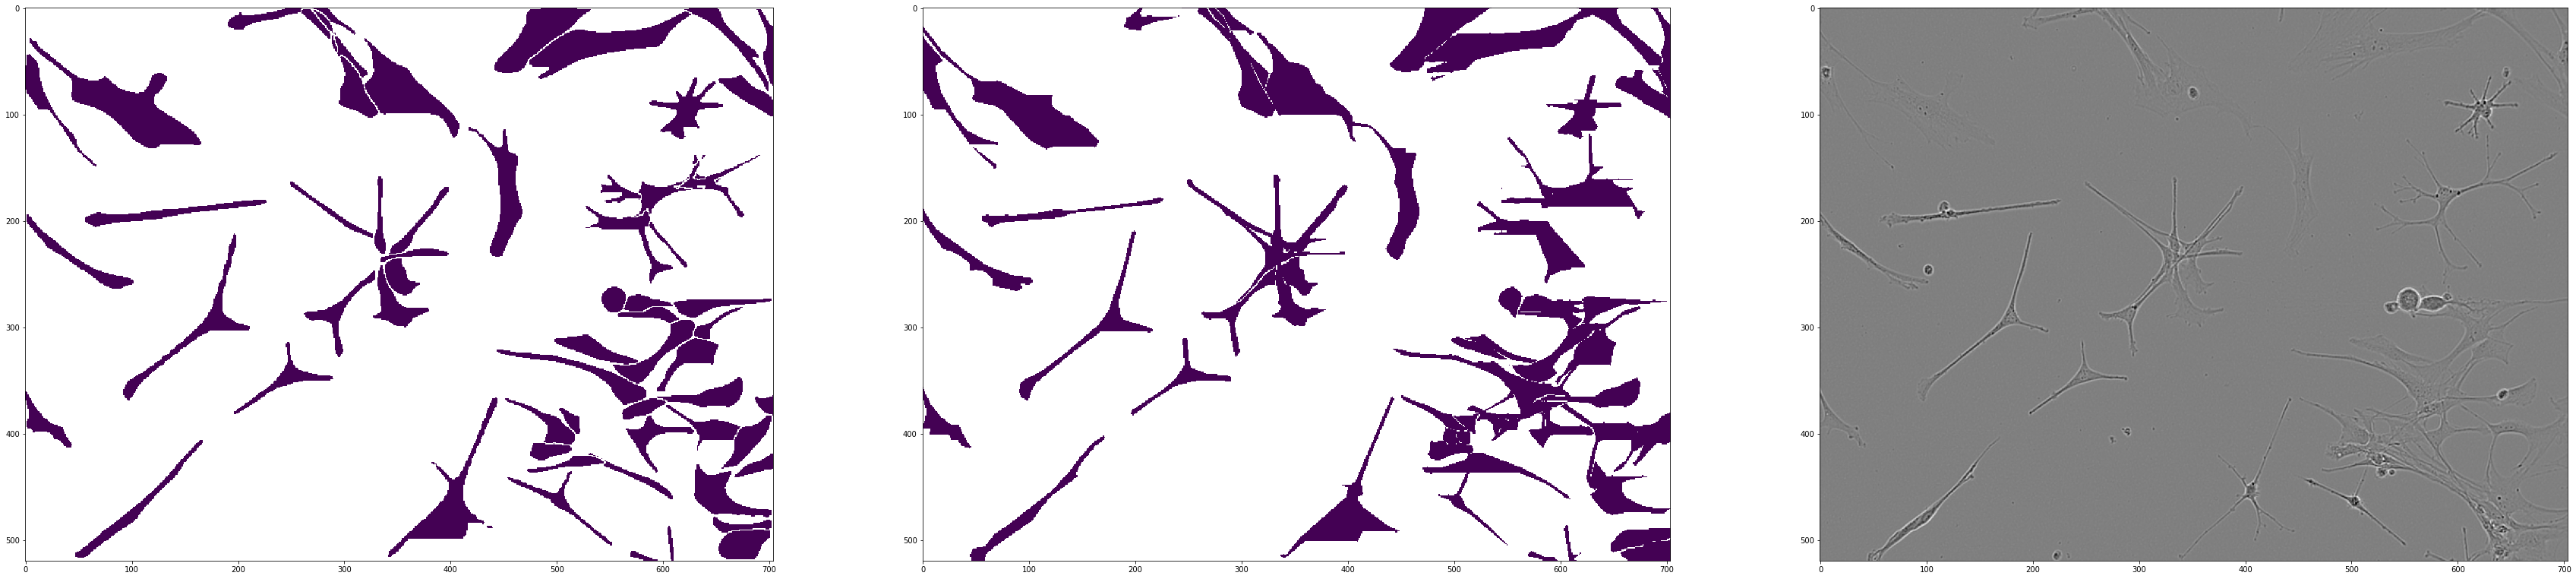

In [18]:
fn=str(train_names[1])
idx=fn.split('/')[-1].replace('.png','')
encoded_masks = get_masks(fn, predictors)

_, axs = plt.subplots(1,3, figsize=(60,15))
axs[2].imshow(cv2.imread(str(fn)))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))
for enc in train_df.query('id==@idx').annotation:
    dec = rle_decode(enc)
    axs[1].imshow(np.ma.masked_where(dec==0, dec))
print(len(encoded_masks),len(train_df.query('id==@idx').annotation))
plt.show()

In [19]:
for fn in test_names:
    try:
        encoded_masks = get_masks(fn, predictors)
        if len(encoded_masks)==0:
            ids.append(fn.stem)
            masks.append('')
        else:
            for enc in encoded_masks:
                ids.append(fn.stem)
                masks.append(enc)
    except:
        ids.append(fn.stem)
        masks.append('')

In [20]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,140245 5 140948 7 141651 9 142355 10 143059 10...
1,7ae19de7bc2a,140003 16 140706 21 141410 22 142113 23 142818...
2,7ae19de7bc2a,148932 5 149634 8 150337 10 151039 13 151742 1...
3,7ae19de7bc2a,177491 1 178194 3 178897 5 179600 6 180304 6 1...
4,7ae19de7bc2a,96418 4 97121 6 97825 7 98528 9 99232 10 99936...
